# Holmusk Challenge: Finding Factors Driving Cost Of Care

## Contents
- [Task](#Task)
- [Background](#Background)
- [Problem Statement](#Problem-Statement)
- [Objectives](#Objectives)
- [Data Preparation](#Data-Preparation)
- [Exploration & Visualisation](#Exploration-&-Visualisation)
- [Pre-Processing & Modelling](#Pre-Processing-&-Modelling)
- [Recommendations](#Recommendations)
- [Limitations](#Limitations)
- [Conclusion](#Conclusion)
- [References](#References)

## Task

The task is to analyse the clinical and financial data of patients hospitalised for a certain condition. Some variable names and patient id's have been anonymised in this dataset. It is required to join the data given in different tables, and find insights about the drivers of cost of care.

## Background

Healthcare costs in Singapore have been rising and are expected to keep increasing over the coming years [[1]](https://www.dbs.com.sg/personal/articles/nav/protection/guide-health-insurance-singapore-medishield-medisave?pid=sg-dbs-pweb-insure-product-firstinsurance-image-textlink-medishield-medisave). Part of the rising costs have been attributed to health insurance policies with full riders that cover hospital bills in full as they may have contributed to over-consumption by policyholders and over-charging of medical services [[2]](https://www.dbs.com.sg/personal/articles/nav/protection/integrated-shield-plans). Health insurers have had to adjust the terms for full-rider health insurance policies to require co-payment of hospital bills in order to keep healthcare costs down [[3]](https://www.straitstimes.com/singapore/health/moh-welcomes-measures-by-insurers-to-adjust-terms-for-full-rider-ips-and-require-co).

## Problem Statement

Against a backdrop of rising healthcare costs, ABC Health Insurance would like to understand the factors driving cost of care in order to structure their policy offerings in a way that remains competitive, attractive, and sustainable in the long run. To achieve this, they need to ensure that premiums are kept affordable, that plans are able to meet the needs of policyholders, and that claim payouts do not exceed cash revenue.

## Objectives

The objectives of this project are to:
- Explore the data and visualise individual variables as well as the relationships between independent variables and bill amount
- Predict bill amount by training 3 regression models (linear, ridge, lasso) and evaluate them using 2 metrics (R², RMSE) to select the best performing model
- Analyse the final model for the accuracy of its predictions and the weights of its features
- Find the main factors driving cost of care (i.e. the features which are most important in explaining bill amount)
- Make recommendations that address the issue of rising healthcare costs

## Data Preparation

### Libraries Needed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_squared_error

from pathlib import Path

In [2]:
data_dir = Path('../data')
data_dir.mkdir(parents=True, exist_ok=True)
plots_dir = Path('../plots')
plots_dir.mkdir(parents=True, exist_ok=True)

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 100

### Data Sources

The following datasets were used:

* [`bill_amount.csv`](../data/bill_amount.csv): Bill Amount Dataset

> This dataset contains a listing of the bill IDs and the corresponding bill amounts. There are 13,600 rows and 2 columns.

* [`bill_id.csv`](../data/bill_id.csv): Bill ID Dataset

> This dataset contains a listing of the bill IDs and the corresponding patient IDs and dates of admission. It is from the period 2011 to 2015. There are 13,600 rows and 3 columns.

* [`clinical_data.csv`](../data/clinical_data.csv): Clinical Dataset

> This dataset contains a listing of the patient IDs and the dates of admission. It is from the period 2011 to 2015. For each patient admission, there is information on the patient's date of discharge, medical histories, pre-op medications, symptoms, lab results, weight, and height. There are 3,400 rows and 26 columns.

* [`demographics.csv`](../data/demographics.csv): Demographics Dataset

> This dataset contains a listing of the patient IDs and their corresponding gender, race, resident status, and date of birth. There are 3,000 rows and 5 columns.

### Data Importing

#### Import Bill Amount Dataset

In [4]:
# import bill amount dataset
amt = pd.read_csv(data_dir.joinpath('bill_amount.csv'))

In [5]:
# check out head
amt.head()

,bill_id,amount
0,40315104,1552.634830
1,2660045161,1032.011951
2,1148334643,6469.605351
3,3818426276,755.965425
4,9833541918,897.347816


In [6]:
# check out shape
amt.shape

(13600, 2)

#### Import Bill ID Dataset

In [7]:
# import bill id dataset
key = pd.read_csv(data_dir.joinpath('bill_id.csv'))

In [8]:
# check out head
key.head()

,bill_id,patient_id,date_of_admission
0,7968360812,1d21f2be18683991eb93d182d6b2d220,2011-01-01
1,6180579974,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
2,7512568183,1d21f2be18683991eb93d182d6b2d220,2011-01-01
3,3762633379,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
4,7654730355,1d21f2be18683991eb93d182d6b2d220,2011-01-01


In [9]:
# check out shape
key.shape

(13600, 3)

#### Import Clinical Dataset

In [10]:
# import clinical dataset
clin = pd.read_csv(data_dir.joinpath('clinical_data.csv'))

In [11]:
# check out head
clin.head()

,id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1.0,0,0,0.0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0.0,0,0,0.0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0.0,0,0,0.0,0,0,0,1,1,1,1,1,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0
3,e0397dd72caf4552c5babebd3d61736c,2011-01-02,2011-01-14,0,1.0,No,0,0.0,1,1,1,0,1,0,0,1,1,1,1,1,1,13.3,28.4,76.0,64.4,152.0
4,94ade3cd5f66f4584902554dff170a29,2011-01-08,2011-01-16,0,0.0,No,0,0.0,1,1,0,0,0,0,1,0,0,1,0,1,0,12.0,27.8,87.0,55.6,160.0


In [12]:
# check out shape
clin.shape

(3400, 26)

#### Import Demographics Dataset

In [13]:
# import demographics dataset
demo = pd.read_csv(data_dir.joinpath('demographics.csv'))

In [14]:
# check out head
demo.head()

,patient_id,gender,race,resident_status,date_of_birth
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singaporean,1971-05-14
1,5b6477c5de78d0b138e3b0c18e21d0ae,f,Chinese,Singapore citizen,1976-02-18
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03
3,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15
4,541ad077cb4a0e64cc422673afe28aef,m,Chinese,Singaporean,1970-12-12


In [15]:
# check out shape
demo.shape

(3000, 5)

### Data Cleaning

The datasets will be cleaned in the following order:
1. Bill Amount Dataset
2. Bill ID Dataset
3. Clinical Dataset
4. Demographics Dataset

The cleaning of the data will involve:
- Renaming columns
- Removing duplicates
- Fixing null values
- Correcting column data types
- Ensuring categorical columns have logical unique values
- Ensuring numerical columns have reasonable min and max values

#### Clean Bill Amount Dataset

In [16]:
# rename columns
amt = amt.rename(columns={'amount': 'bill_amount'})
amt.columns

Index(['bill_id', 'bill_amount'], dtype='object')

In [17]:
# check for duplicates
amt[amt.duplicated()]

,bill_id,bill_amount


In [18]:
# check for null values
amt.isnull().sum().sort_values(ascending=False).apply(lambda x: f'{x:,} ({x/len(amt):.1%})')

bill_id        0 (0.0%)
bill_amount    0 (0.0%)
dtype: object

In [19]:
# check out column data types
amt.dtypes

bill_id          int64
bill_amount    float64
dtype: object

In [20]:
# check that numerical columns have reasonable min and max values
amt.describe().loc[['min', 'max'], ['bill_amount']]

,bill_amount
min,79.496707
max,81849.751340


In [21]:
# check out shape, non-null count, and column data types again
amt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13600 entries, 0 to 13599
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bill_id      13600 non-null  int64  
 1   bill_amount  13600 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 212.6 KB


#### Clean Bill ID Dataset

In [22]:
# check for duplicates
key[key.duplicated()]

,bill_id,patient_id,date_of_admission


In [23]:
# check for null values
key.isnull().sum().sort_values(ascending=False).apply(lambda x: f'{x:,} ({x/len(key):.1%})')

bill_id              0 (0.0%)
patient_id           0 (0.0%)
date_of_admission    0 (0.0%)
dtype: object

In [24]:
# convert date_of_admission column to datetime
key['date_of_admission'] = pd.to_datetime(key['date_of_admission'])

In [25]:
# check out column data types
key.dtypes

bill_id                       int64
patient_id                   object
date_of_admission    datetime64[ns]
dtype: object

In [26]:
# check out shape, non-null count, and column data types again
key.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13600 entries, 0 to 13599
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   bill_id            13600 non-null  int64         
 1   patient_id         13600 non-null  object        
 2   date_of_admission  13600 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 318.9+ KB


#### Clean Clinical Dataset

In [27]:
# see values in columns
clin.head()

,id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1.0,0,0,0.0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0.0,0,0,0.0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0.0,0,0,0.0,0,0,0,1,1,1,1,1,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0
3,e0397dd72caf4552c5babebd3d61736c,2011-01-02,2011-01-14,0,1.0,No,0,0.0,1,1,1,0,1,0,0,1,1,1,1,1,1,13.3,28.4,76.0,64.4,152.0
4,94ade3cd5f66f4584902554dff170a29,2011-01-08,2011-01-16,0,0.0,No,0,0.0,1,1,0,0,0,0,1,0,0,1,0,1,0,12.0,27.8,87.0,55.6,160.0


**Observation:** `medical_history_3` is a binary categorical column holding information in the form of 0 or 'No' to indicate absent and 1 or 'Yes' to indicate present. Let us standardise the entries in this 1 column to reflect the correct number of unique categories.

In [28]:
# count values in medical_history_3 column 
clin['medical_history_3'].value_counts()

0      2176
No      761
1       348
Yes     115
Name: medical_history_3, dtype: int64

In [29]:
# standardise entries in medical_history_3 column
clin['medical_history_3'] = clin['medical_history_3'].map(
    {'0': 0,
     '1': 1,
     'No': 0,
     'Yes': 1,
    }
).fillna(clin['medical_history_3']).astype('int')
clin['medical_history_3'].value_counts()

0    2937
1     463
Name: medical_history_3, dtype: int64

In [30]:
# rename columns 
clin = clin.rename(columns={'id': 'patient_id'})
clin.columns

Index(['patient_id', 'date_of_admission', 'date_of_discharge',
       'medical_history_1', 'medical_history_2', 'medical_history_3',
       'medical_history_4', 'medical_history_5', 'medical_history_6',
       'medical_history_7', 'preop_medication_1', 'preop_medication_2',
       'preop_medication_3', 'preop_medication_4', 'preop_medication_5',
       'preop_medication_6', 'symptom_1', 'symptom_2', 'symptom_3',
       'symptom_4', 'symptom_5', 'lab_result_1', 'lab_result_2',
       'lab_result_3', 'weight', 'height'],
      dtype='object')

In [31]:
# check for duplicates
clin[clin.duplicated()]

,patient_id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height


In [32]:
# check for null values
clin.isnull().sum().sort_values(ascending=False).apply(lambda x: f'{x:,} ({x/len(clin):.1%})')

medical_history_5     304 (8.9%)
medical_history_2     233 (6.9%)
patient_id              0 (0.0%)
preop_medication_5      0 (0.0%)
weight                  0 (0.0%)
lab_result_3            0 (0.0%)
lab_result_2            0 (0.0%)
lab_result_1            0 (0.0%)
symptom_5               0 (0.0%)
symptom_4               0 (0.0%)
symptom_3               0 (0.0%)
symptom_2               0 (0.0%)
symptom_1               0 (0.0%)
preop_medication_6      0 (0.0%)
preop_medication_4      0 (0.0%)
date_of_admission       0 (0.0%)
preop_medication_3      0 (0.0%)
preop_medication_2      0 (0.0%)
preop_medication_1      0 (0.0%)
medical_history_7       0 (0.0%)
medical_history_6       0 (0.0%)
medical_history_4       0 (0.0%)
medical_history_3       0 (0.0%)
medical_history_1       0 (0.0%)
date_of_discharge       0 (0.0%)
height                  0 (0.0%)
dtype: object

**Observation:** `medical_history_5` and `medical_history_2` are binary categorical columns containing 0 for absent and 1 for present. Let us the fill null values in these 2 columns with 0 under the assumption that missing values indicate absence of that medical history.

In [33]:
# fill null values in medical_history_5 column with 0
clin['medical_history_5'] = clin['medical_history_5'].fillna(0).astype('int')
print('Null Values:', clin['medical_history_5'].isnull().sum())
print('Data Type:', clin['medical_history_5'].dtype)

Null Values: 0
Data Type: int64


In [34]:
# fill null values in medical_history_2 column with 0
clin['medical_history_2'] = clin['medical_history_2'].fillna(0).astype('int')
print('Null Values:', clin['medical_history_2'].isnull().sum())
print('Data Type:', clin['medical_history_2'].dtype)

Null Values: 0
Data Type: int64


In [35]:
# convert date_of_admission column and date_of_discharge column to datetime
clin['date_of_admission'] = pd.to_datetime(clin['date_of_admission'])
clin['date_of_discharge'] = pd.to_datetime(clin['date_of_discharge'])

In [36]:
# check out column data types
clin.dtypes

patient_id                    object
date_of_admission     datetime64[ns]
date_of_discharge     datetime64[ns]
medical_history_1              int64
medical_history_2              int64
medical_history_3              int64
medical_history_4              int64
medical_history_5              int64
medical_history_6              int64
medical_history_7              int64
preop_medication_1             int64
preop_medication_2             int64
preop_medication_3             int64
preop_medication_4             int64
preop_medication_5             int64
preop_medication_6             int64
symptom_1                      int64
symptom_2                      int64
symptom_3                      int64
symptom_4                      int64
symptom_5                      int64
lab_result_1                 float64
lab_result_2                 float64
lab_result_3                 float64
weight                       float64
height                       float64
dtype: object

In [37]:
# check that numerical columns have reasonable min and max values
clin.describe().loc[['min', 'max']]

,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.1,19.7,52.0,48.0,151.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,20.3,35.1,150.0,121.0,186.0


In [38]:
# check out shape, non-null count, and column data types again
clin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   patient_id          3400 non-null   object        
 1   date_of_admission   3400 non-null   datetime64[ns]
 2   date_of_discharge   3400 non-null   datetime64[ns]
 3   medical_history_1   3400 non-null   int64         
 4   medical_history_2   3400 non-null   int64         
 5   medical_history_3   3400 non-null   int64         
 6   medical_history_4   3400 non-null   int64         
 7   medical_history_5   3400 non-null   int64         
 8   medical_history_6   3400 non-null   int64         
 9   medical_history_7   3400 non-null   int64         
 10  preop_medication_1  3400 non-null   int64         
 11  preop_medication_2  3400 non-null   int64         
 12  preop_medication_3  3400 non-null   int64         
 13  preop_medication_4  3400 non-null   int64       

#### Clean Demographics Dataset

In [39]:
# see values in columns
demo.head()

,patient_id,gender,race,resident_status,date_of_birth
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singaporean,1971-05-14
1,5b6477c5de78d0b138e3b0c18e21d0ae,f,Chinese,Singapore citizen,1976-02-18
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03
3,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15
4,541ad077cb4a0e64cc422673afe28aef,m,Chinese,Singaporean,1970-12-12


**Observation:** `gender`, `race`, and `resident_status` have values that belong to the same category but have been named in different ways. Let us standardise the entries in these 3 columns to reflect the correct number of unique categories.

In [40]:
# count values in gender column 
demo['gender'].value_counts()

Female    1396
Male      1333
m          170
f          101
Name: gender, dtype: int64

In [41]:
# standardise entries in gender column
demo['gender'] = demo['gender'].map({'m': 'Male', 'f': 'Female'}).fillna(demo['gender'])
demo['gender'].value_counts()

Male      1503
Female    1497
Name: gender, dtype: int64

In [42]:
# count values in race column
demo['race'].value_counts()

Chinese    1608
Malay       629
chinese     307
Indian      195
Others      161
India       100
Name: race, dtype: int64

In [43]:
# standardise entries in race column
demo['race'] = demo['race'].map({'chinese': 'Chinese', 'India': 'Indian'}).fillna(demo['race'])
demo['race'].value_counts()

Chinese    1915
Malay       629
Indian      295
Others      161
Name: race, dtype: int64

In [44]:
# count values in resident_status column
demo['resident_status'].value_counts()

Singaporean          1782
Singapore citizen     610
PR                    465
Foreigner             143
Name: resident_status, dtype: int64

In [45]:
# standardise entries in resident_status column
demo['resident_status'] = demo['resident_status'].map(
    {'Singaporean': 'SG Citizen',
     'Singapore citizen': 'SG Citizen',
     'PR': 'SG PR',
    }
).fillna(demo['resident_status'])
demo['resident_status'].value_counts()

SG Citizen    2392
SG PR          465
Foreigner      143
Name: resident_status, dtype: int64

In [46]:
# check for duplicates
demo[demo.duplicated()]

,patient_id,gender,race,resident_status,date_of_birth


In [47]:
# check for null values
demo.isnull().sum().sort_values(ascending=False).apply(lambda x: f'{x:,} ({x/len(demo):.1%})')

patient_id         0 (0.0%)
gender             0 (0.0%)
race               0 (0.0%)
resident_status    0 (0.0%)
date_of_birth      0 (0.0%)
dtype: object

In [48]:
# convert date_of_admission column to datetime
demo['date_of_birth'] = pd.to_datetime(demo['date_of_birth'])

In [49]:
# check out column data types
demo.dtypes

patient_id                 object
gender                     object
race                       object
resident_status            object
date_of_birth      datetime64[ns]
dtype: object

In [50]:
# check that categorical columns have logical unique values
demo.describe(include=['object']).loc[['unique'], ['gender', 'race', 'resident_status']]

,gender,race,resident_status
unique,2,4,3


In [51]:
# check out shape, non-null count, and column data types again
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   patient_id       3000 non-null   object        
 1   gender           3000 non-null   object        
 2   race             3000 non-null   object        
 3   resident_status  3000 non-null   object        
 4   date_of_birth    3000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 117.3+ KB


### Data Merging

#### Merge 1: Bill Amount Dataset & Bill ID Dataset

In [52]:
# merge bill amount dataset with bill id dataset on bill id
bill = pd.merge(amt, key, how='left', on='bill_id')
bill

,bill_id,bill_amount,patient_id,date_of_admission
0,40315104,1552.634830,96a76ec5bbcb1d1562c40b9b972e356d,2012-10-22
1,2660045161,1032.011951,796de06efdad342d3f3a379dff0bd63c,2014-09-28
2,1148334643,6469.605351,1ce104904e9160cf3cfdb3c45b9ce4ff,2014-01-16
3,3818426276,755.965425,afdfe7216d84e13708a19cbca288379a,2013-01-22
4,9833541918,897.347816,b9a0c119dc07e07f88281964f3a4869f,2011-04-22
...,...,...,...,...
13595,9046631672,1281.877819,e6b86ad95044e2e5544a10d32dc3e4d4,2013-12-02
13596,932340787,873.625512,848309c0d0848eea411ccd9e12cb0513,2015-10-05
13597,343247663,698.281172,30ad466717b7a6e9e6a22578572438b5,2014-01-25
13598,2953100420,1220.967486,874491426098c8bc16b4620d8aaabc2d,2011-07-25


In [53]:
# sort dataframe by patient id and date of admission
bill = bill[
    [
        'patient_id',
        'date_of_admission',
        'bill_id',
        'bill_amount',
    ]
].sort_values(['patient_id', 'date_of_admission'], ascending=True)
bill

,patient_id,date_of_admission,bill_id,bill_amount
1358,00225710a878eff524a1d13be817e8e2,2014-04-10,4692776325,325.319345
1803,00225710a878eff524a1d13be817e8e2,2014-04-10,8461069832,1074.885913
4760,00225710a878eff524a1d13be817e8e2,2014-04-10,5175703971,79.496707
12021,00225710a878eff524a1d13be817e8e2,2014-04-10,7746811189,3710.864731
1591,0029d90eb654699c18001c17efb0f129,2012-11-07,645202091,16460.718669
...,...,...,...,...
11986,ffd67c2bcfb32508d2cf7b1e1193e2ed,2012-12-24,5401991269,1266.739021
2518,ffd9644f8daf1d28493a7cd700bb30f4,2013-06-04,7388693307,1475.253239
4691,ffd9644f8daf1d28493a7cd700bb30f4,2013-06-04,7767844278,416.301352
7088,ffd9644f8daf1d28493a7cd700bb30f4,2013-06-04,7406466784,18208.655474


**Observation:** For each unique combination of patient id and date of admission, there appears to be multiple bill ids and bill amounts. This could be because the patient is being billed separately by different departments in the hospital that have rendered their services to the patient (e.g. pharmacy, radiology, laboratory). Let us see if this is consistent for the whole dataframe by grouping by patient id and date of admission.

In [54]:
# group dataframe by patient id and date of admission
bill.groupby(['patient_id', 'date_of_admission']).count().sort_values('bill_id', ascending=True)

,,bill_id,bill_amount
patient_id,date_of_admission,,
00225710a878eff524a1d13be817e8e2,2014-04-10,4,4
acb854cb2bfc0f16ec3e03b4c064c1dc,2011-10-17,4,4
acbb80680632022aa02d3ec05f48ade9,2015-01-17,4,4
acc2e1149568866cd376d8fe3756eec5,2015-10-20,4,4
ace8eb9a48c16c396aca11f9e55efe5c,2015-01-13,4,4
...,...,...,...
556869c949c3e6e2b120cc358cc2c412,2011-06-02,4,4
556d008069ee016440d4c582df3ce989,2013-06-16,4,4
5579e8edf239904ab2414095f345c0f9,2013-03-09,4,4


**Observation:** There are 3,400 unique rows of patient id and date of admission. For each unique combination of patient id and date of admission, there are 4 bill ids and bill amounts. Since it is not known which department each bill originated from, the total bill for each patient's hospitalisation will be studied instead. Let us proceed to sum the bill amounts for observations with the same patient id and same date of admission. This ensures that there will only be 1 bill amount for each unique combination of patient id and date of admission.

In [55]:
# sum bill amounts for observations with the same patient id and same date of admission
bill = bill.groupby(['patient_id', 'date_of_admission'], as_index=False).sum()
bill

,patient_id,date_of_admission,bill_id,bill_amount
0,00225710a878eff524a1d13be817e8e2,2014-04-10,26076361317,5190.566695
1,0029d90eb654699c18001c17efb0f129,2012-11-07,14912992947,22601.497872
2,0040333abd68527ecb53e1db9073f52e,2013-01-19,25839165421,17447.181635
3,00473b58e3dc8ae37b3cb34069705083,2014-02-10,18672163438,15285.883220
4,0078662d1d983dde68ea057c42d5b5cf,2012-04-28,27555446189,73477.869010
...,...,...,...,...
3395,ffa5a615a4cc5fb1ada0443edc1f5dd3,2011-04-24,28365460057,4676.066179
3396,ffac3c4b6838f42625e1dd00dd7c867b,2015-11-28,11999610855,14049.042774
3397,ffc19537fa6621512ef4f296d60896ce,2013-05-05,12784053233,30053.620971
3398,ffd67c2bcfb32508d2cf7b1e1193e2ed,2012-12-24,18859430162,28007.636468


**Observation:** `bill_id` will be dropped since it is unique to each observation and will not be needed for merging with the other datasets.

In [56]:
# drop bill_id column
bill = bill.drop(columns='bill_id')

#### Merge 2: Clinical Dataset & Demographics Dataset

In [57]:
# merge clinical dataset with demographics dataset on patient id
patient = pd.merge(clin, demo, how='left', on='patient_id')
patient

,patient_id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,date_of_birth
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0,Male,Indian,SG Citizen,1976-12-19
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0,Female,Malay,SG Citizen,1978-07-20
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0,Female,Indian,SG Citizen,1967-08-14
3,e0397dd72caf4552c5babebd3d61736c,2011-01-02,2011-01-14,0,1,0,0,0,1,1,1,0,1,0,0,1,1,1,1,1,1,13.3,28.4,76.0,64.4,152.0,Female,Chinese,SG PR,1967-12-06
4,94ade3cd5f66f4584902554dff170a29,2011-01-08,2011-01-16,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,12.0,27.8,87.0,55.6,160.0,Female,Others,SG PR,1982-07-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,4368c266084e640c469a5d41b339805c,2015-12-26,2016-01-07,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1,1,13.8,28.6,129.0,79.5,167.0,Female,Chinese,SG Citizen,1964-01-05
3396,4f67a54ab205cc9e7e2b0a4ee08e4fba,2015-12-28,2016-01-07,0,0,0,0,0,1,0,1,1,1,0,1,1,1,1,0,0,1,11.6,27.9,107.0,72.7,155.0,Female,Chinese,SG Citizen,1970-08-07
3397,ac52a32f8ce8c46d82df2d72052ae5a9,2015-12-28,2016-01-08,0,0,0,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,14.7,25.2,91.0,62.3,154.0,Female,Chinese,SG Citizen,1979-03-06
3398,5189c62dfb8e6075b5c7fd4766671bd4,2015-12-26,2016-01-09,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,16.9,25.6,92.0,87.3,156.0,Female,Chinese,SG Citizen,1960-05-10


In [58]:
# find number of unique patient ids
patient['patient_id'].nunique()

3000

**Observation:** There are 3,000 unique patient ids and 3,400 rows in the dataframe. This means that the dataframe has patients who have had more than 1 admission. In other words, there are some patient ids that have multiple dates of admission. Hence, the merger between this patient dataset and the bill dataset must happen not just on patient id but also on date of admission. 

#### Merge 3: Patient Dataset & Bill Dataset

In [59]:
# merge patient dataset with bill dataset on patient id and date of admission
df = pd.merge(patient, bill, how='left', on=['patient_id', 'date_of_admission'])
df

,patient_id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,date_of_birth,bill_amount
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0,Male,Indian,SG Citizen,1976-12-19,15405.418665
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0,Female,Malay,SG Citizen,1978-07-20,23303.000924
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0,Female,Indian,SG Citizen,1967-08-14,16813.123088
3,e0397dd72caf4552c5babebd3d61736c,2011-01-02,2011-01-14,0,1,0,0,0,1,1,1,0,1,0,0,1,1,1,1,1,1,13.3,28.4,76.0,64.4,152.0,Female,Chinese,SG PR,1967-12-06,27994.878530
4,94ade3cd5f66f4584902554dff170a29,2011-01-08,2011-01-16,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,12.0,27.8,87.0,55.6,160.0,Female,Others,SG PR,1982-07-18,10707.950907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,4368c266084e640c469a5d41b339805c,2015-12-26,2016-01-07,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1,1,13.8,28.6,129.0,79.5,167.0,Female,Chinese,SG Citizen,1964-01-05,20730.378614
3396,4f67a54ab205cc9e7e2b0a4ee08e4fba,2015-12-28,2016-01-07,0,0,0,0,0,1,0,1,1,1,0,1,1,1,1,0,0,1,11.6,27.9,107.0,72.7,155.0,Female,Chinese,SG Citizen,1970-08-07,19356.767331
3397,ac52a32f8ce8c46d82df2d72052ae5a9,2015-12-28,2016-01-08,0,0,0,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,14.7,25.2,91.0,62.3,154.0,Female,Chinese,SG Citizen,1979-03-06,20141.411600
3398,5189c62dfb8e6075b5c7fd4766671bd4,2015-12-26,2016-01-09,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,16.9,25.6,92.0,87.3,156.0,Female,Chinese,SG Citizen,1960-05-10,10932.663154


### Data Exporting I

In [60]:
# check out head
df.head()

,patient_id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,date_of_birth,bill_amount
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0,Male,Indian,SG Citizen,1976-12-19,15405.418665
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0,Female,Malay,SG Citizen,1978-07-20,23303.000924
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0,Female,Indian,SG Citizen,1967-08-14,16813.123088
3,e0397dd72caf4552c5babebd3d61736c,2011-01-02,2011-01-14,0,1,0,0,0,1,1,1,0,1,0,0,1,1,1,1,1,1,13.3,28.4,76.0,64.4,152.0,Female,Chinese,SG PR,1967-12-06,27994.878530
4,94ade3cd5f66f4584902554dff170a29,2011-01-08,2011-01-16,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,12.0,27.8,87.0,55.6,160.0,Female,Others,SG PR,1982-07-18,10707.950907


In [61]:
# check out shape
df.shape

(3400, 31)

In [62]:
# export dataframe
df.to_csv(data_dir.joinpath('health_cleaned.csv'), index=False)

### Feature Engineering

The following features will be engineered to extract more useful information from the dataset:
- Year Of Admission
- Month Of Admission
- Age At Admission
- Days Hospitalised
- Hospitalisation Count
- Days Since Last Hospitalisation
- Number Of Medical Histories
- Number Of Pre-Op Medications
- Number Of Symptoms
- Body Mass Index

#### Year Of Admission

We can explore if there are any trends in the year of admission with respect to the bill amount.

In [63]:
# create a new column for year of admission
df['year_of_admission'] = df['date_of_admission'].dt.year.astype('object')
df[['date_of_admission', 'year_of_admission']].head(1)

,date_of_admission,year_of_admission
0,2011-01-01,2011


#### Month Of Admission

We can explore if there are any trends in the month of admission with respect to the bill amount.

In [64]:
# create a new column for month of admission
df['month_of_admission'] = df['date_of_admission'].dt.month.astype('object')
df[['date_of_admission', 'month_of_admission']].head(1)

,date_of_admission,month_of_admission
0,2011-01-01,1


#### Age At Admission

We can expect the bill amount to be larger for older patients as they would usually require more services (e.g. drugs, scans, tests) during their hospitalisation due to them generally having more comorbidities and vice versa.

In [65]:
# create a new column for age at admission
df['age_at_admission'] = round((df['date_of_admission'] - df['date_of_birth']).dt.days / 365, 0)
df['age_at_admission'] = df['age_at_admission'].astype('int')
df[['date_of_admission', 'date_of_birth', 'age_at_admission']].head(1)

,date_of_admission,date_of_birth,age_at_admission
0,2011-01-01,1976-12-19,34


#### Days Hospitalised

We can expect the bill amount to be larger for patients who have been hospitalised longer and vice versa.

In [66]:
# create a new column for days hospitalised
df['days_hosp'] = (df['date_of_discharge'] - df['date_of_admission']).dt.days + 1
df[['date_of_admission', 'date_of_discharge', 'days_hosp']].head(1)

,date_of_admission,date_of_discharge,days_hosp
0,2011-01-01,2011-01-11,11


#### Hospitalisation Count

We can investigate the effect of recurring hospitalisations and see if every subsequent admission contributes to a larger bill amount.

In [67]:
# create a new column for hospitalisation count
df['hosp_count'] = df.groupby('patient_id').cumcount() + 1
df[['hosp_count']].head(1)

,hosp_count
0,1


In [68]:
# check that hospitalisation count is correct
df.loc[df['patient_id'] == '4e46fddfa404b306809c350aecbf0f6a', 
       ['patient_id', 'date_of_admission', 'date_of_discharge', 'hosp_count']]

,patient_id,date_of_admission,date_of_discharge,hosp_count
634,4e46fddfa404b306809c350aecbf0f6a,2011-11-23,2011-12-05,1
1356,4e46fddfa404b306809c350aecbf0f6a,2013-01-06,2013-01-17,2
1391,4e46fddfa404b306809c350aecbf0f6a,2013-01-23,2013-02-02,3
1823,4e46fddfa404b306809c350aecbf0f6a,2013-09-16,2013-09-27,4


In [69]:
# check for any anomalies
df[df['hosp_count'] < 1]

,patient_id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,date_of_birth,bill_amount,year_of_admission,month_of_admission,age_at_admission,days_hosp,hosp_count


#### Days Since Last Hospitalisation

We can investigate the effect of recurring hospitalisations and see if the time in days that has elapsed between the last date of admission and the current date of admission has any effect in influencing the bill amount.

In [70]:
# create a new column for days since last hospitalisation
df['days_since_last_hosp'] = df.groupby('patient_id')['date_of_admission'].diff() \
                            .apply(lambda x: x.days).fillna(0).astype('int')
df[['days_since_last_hosp']].head(1)

,days_since_last_hosp
0,0


In [71]:
# check that days since last hospitalisation is correct
df.loc[df['patient_id'] == '4e46fddfa404b306809c350aecbf0f6a', 
       ['patient_id', 'date_of_admission', 'date_of_discharge', 'days_since_last_hosp']]

,patient_id,date_of_admission,date_of_discharge,days_since_last_hosp
634,4e46fddfa404b306809c350aecbf0f6a,2011-11-23,2011-12-05,0
1356,4e46fddfa404b306809c350aecbf0f6a,2013-01-06,2013-01-17,410
1391,4e46fddfa404b306809c350aecbf0f6a,2013-01-23,2013-02-02,17
1823,4e46fddfa404b306809c350aecbf0f6a,2013-09-16,2013-09-27,236


In [72]:
# check for any anomalies
df[df['days_since_last_hosp'] < 0]

,patient_id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,date_of_birth,bill_amount,year_of_admission,month_of_admission,age_at_admission,days_hosp,hosp_count,days_since_last_hosp
1872,cece24b4e421427ed5cc8e5ba44fadde,2013-10-05,2013-10-20,0,0,0,0,0,1,0,1,1,1,0,1,0,0,1,0,1,0,17.0,25.1,108.0,73.1,164.0,Male,Others,SG Citizen,1944-06-12,16449.766887,2013,10,69,16,2,-3


In [73]:
# investigate any anomalies
df[df['patient_id'] == 'cece24b4e421427ed5cc8e5ba44fadde']

,patient_id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,gender,race,resident_status,date_of_birth,bill_amount,year_of_admission,month_of_admission,age_at_admission,days_hosp,hosp_count,days_since_last_hosp
1869,cece24b4e421427ed5cc8e5ba44fadde,2013-10-08,2013-10-19,0,0,1,0,0,0,0,1,0,1,1,1,0,0,0,0,1,0,15.4,25.2,101.0,72.1,164.0,Male,Others,SG Citizen,1944-06-12,9080.075225,2013,10,69,12,1,0
1872,cece24b4e421427ed5cc8e5ba44fadde,2013-10-05,2013-10-20,0,0,0,0,0,1,0,1,1,1,0,1,0,0,1,0,1,0,17.0,25.1,108.0,73.1,164.0,Male,Others,SG Citizen,1944-06-12,16449.766887,2013,10,69,16,2,-3


**Observation:** It appears that there is 1 patient with 2 overlapping hospitalisations. This could be caused by human error during data entry. Since we do not know if they should be 2 different patients or if they should be 1 patient but the dates of admission and discharge are erroneous, we will rectify it by keeping the 2 rows and resetting the values in hospitalisation count and days since last hospitalisation.

In [74]:
# rectify any anomalies
df.loc[1872, 'hosp_count'] = 1
df.loc[1872, 'days_since_last_hosp'] = 0

#### Number Of Medical Histories

We can expect the bill amount to be larger for patients who had more medical histories due to the greater degree of care that might be needed and vice versa.

In [75]:
# create a new column for number of medical histories
df['num_of_medical_histories'] = df.loc[:, 'medical_history_1': 'medical_history_7'].sum(axis=1)
pd.concat([df.loc[:, 'medical_history_1': 'medical_history_7'], df['num_of_medical_histories']], axis=1).head(1)

,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,num_of_medical_histories
0,0,1,0,0,0,0,0,1


#### Number Of Pre-Op Medications

We can expect the bill amount to be larger for patients who received more pre-op medications and vice versa.

In [76]:
# create a new column for number of pre-op medications
df['num_of_preop_medications'] = df.loc[:, 'preop_medication_1': 'preop_medication_6'].sum(axis=1)
pd.concat([df.loc[:, 'preop_medication_1': 'preop_medication_6'], df['num_of_preop_medications']], axis=1).head(1)

,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,num_of_preop_medications
0,1,0,1,0,0,1,3


#### Number Of Symptoms

We can expect the bill amount to be larger for patients who exhibited more symptoms due to the larger extent of treatment that must be delivered to more complicated cases and vice versa.

In [77]:
# create a new column for number of symptoms
df['num_of_symptoms'] = df.loc[:, 'symptom_1': 'symptom_5'].sum(axis=1)
pd.concat([df.loc[:, 'symptom_1': 'symptom_5'], df['num_of_symptoms']], axis=1).head(1)

,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,num_of_symptoms
0,0,0,0,1,1,2


#### Body Mass Index

BMI gives a more accurate picture of whether a patient is under- or over-weight than weight alone as it takes into consideration the height. We can expect the bill amount to be larger for patients who have a higher BMI due to the higher possibility that they may be suffering from obesity-related diseases such as cardiovascular disease and diabetes that would require more medical attention and vice versa.

In [78]:
# find the min and max values for weight and height to infer their units
df[['weight', 'height']].describe().loc[['min', 'max']]

,weight,height
min,48.0,151.0
max,121.0,186.0


**Inference:** Weight is likely to be in kilograms. Height is likely to be in centimeters.

In [79]:
# create a new column for bmi, which is equal to weight (in kilograms) divided by height (in meters) squared
df['bmi'] = round(df['weight'] / (df['height'] / 100)**2, 1)
df[['weight', 'height', 'bmi']].head(1)

,weight,height,bmi
0,71.3,161.0,27.5


### Data Exporting II

In [80]:
# drop unnecessary columns
df = df.drop(columns=['patient_id', 'date_of_admission', 'date_of_discharge', 'date_of_birth'])

In [81]:
# rearrange columns
df = df[[
    'gender',
    'race',
    'resident_status',
    'year_of_admission',
    'month_of_admission',
    'medical_history_1',
    'medical_history_2',
    'medical_history_3',
    'medical_history_4',
    'medical_history_5',
    'medical_history_6',
    'medical_history_7',
    'preop_medication_1',
    'preop_medication_2',
    'preop_medication_3',
    'preop_medication_4',
    'preop_medication_5',
    'preop_medication_6',
    'symptom_1',
    'symptom_2',
    'symptom_3',
    'symptom_4',
    'symptom_5',
    'lab_result_1',
    'lab_result_2',
    'lab_result_3',
    'weight',
    'height',
    'bmi',
    'age_at_admission',
    'days_hosp',
    'hosp_count',
    'days_since_last_hosp',
    'num_of_medical_histories',
    'num_of_preop_medications',
    'num_of_symptoms',
    'bill_amount',
]]

In [82]:
# check out head
df.head()

,gender,race,resident_status,year_of_admission,month_of_admission,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,bmi,age_at_admission,days_hosp,hosp_count,days_since_last_hosp,num_of_medical_histories,num_of_preop_medications,num_of_symptoms,bill_amount
0,Male,Indian,SG Citizen,2011,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0,27.5,34,11,1,0,1,3,2,15405.418665
1,Female,Malay,SG Citizen,2011,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0,30.6,32,11,1,0,0,4,3,23303.000924
2,Female,Indian,SG Citizen,2011,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0,31.6,43,12,1,0,0,5,4,16813.123088
3,Female,Chinese,SG PR,2011,1,0,1,0,0,0,1,1,1,0,1,0,0,1,1,1,1,1,1,13.3,28.4,76.0,64.4,152.0,27.9,43,13,1,0,3,3,5,27994.878530
4,Female,Others,SG PR,2011,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,12.0,27.8,87.0,55.6,160.0,21.7,28,9,1,0,2,1,2,10707.950907


In [83]:
# check out shape
df.shape

(3400, 37)

In [84]:
# export dataframe
df.to_csv(data_dir.joinpath('health_engineered.csv'), index=False)

### Data Dictionary 

A description of the variables found across all the datasets is given below:

| Variable | Type | Description |
|:---|:---|:---|
| patient_id | object | Patient identification |
| date_of_admission | datetime | Date of admission (in YYYY-MM-DD) |
| date_of_discharge | datetime | Date of discharge (in YYYY-MM-DD) |
| date_of_birth | datetime | Date of birth (in YYYY-MM-DD) |
| gender | object | Gender |
| race | object | Race |
| resident_status | object | Resident status |
| year_of_admission | object | Year of admission |
| month_of_admission | object | Month of admission |
| medical_history_1 | integer | Presence of medical history 1 |
| medical_history_2 | integer | Presence of medical history 2 |
| medical_history_3 | integer | Presence of medical history 3 |
| medical_history_4 | integer | Presence of medical history 4 |
| medical_history_5 | integer | Presence of medical history 5 |
| medical_history_6 | integer | Presence of medical history 6 |
| medical_history_7 | integer | Presence of medical history 7 |
| preop_medication_1 | integer | Presence of pre-op medication 1 |
| preop_medication_2 | integer | Presence of pre-op medication 2 |
| preop_medication_3 | integer | Presence of pre-op medication 3 |
| preop_medication_4 | integer | Presence of pre-op medication 4 |
| preop_medication_5 | integer | Presence of pre-op medication 5 |
| preop_medication_6 | integer | Presence of pre-op medication 6 |
| symptom_1 | integer | Presence of symptom 1 |
| symptom_2 | integer | Presence of symptom 2 |
| symptom_3 | integer | Presence of symptom 3 |
| symptom_4 | integer | Presence of symptom 4 |
| symptom_5 | integer | Presence of symptom 5 |
| lab_result_1 | float | Reading of lab result 1 |
| lab_result_2 | float | Reading of lab result 2 |
| lab_result_3 | float | Reading of lab result 3 |
| weight | float | Weight (in kg) |
| height | float | Height (in cm) |
| bmi | float | Body mass index (in kg/m²) |
| age_at_admission | integer | Age at admission |
| days_hosp | integer | Days hospitalised |
| hosp_count | integer | Hospitalisation count |
| days_since_last_hosp | integer | Days since last hospitalisation |
| num_of_medical_histories | integer | Number of medical histories |
| num_of_preop_medications | integer | Number of pre-op medications |
| num_of_symptoms | integer | Number of symptoms |
| bill_amount | float | Bill amount (in $) |

## Exploration & Visualisation

In [85]:
# map labels from integer to string in these 3 columns: medical_history, preop_medication, symptom
# to aid exploration and visualisation
num_to_cat = df.loc[:, 'medical_history_1': 'symptom_5'].columns
for col in num_to_cat:
    df[col] = df[col].map({0: 'Absent', 1: 'Present'})

### Descriptive Statistics

#### Categorical Columns

In [86]:
# generate descriptive statistics for categorical columns
df.describe(include='object')

,gender,race,resident_status,year_of_admission,month_of_admission,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5
count,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400,3400
unique,2,4,3,5,12,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,Female,Chinese,SG Citizen,2015,10,Absent,Absent,Absent,Absent,Absent,Absent,Absent,Present,Present,Present,Present,Present,Present,Present,Present,Present,Present,Present
freq,1702,2166,2724,692,313,2825,2414,2937,3223,3202,2534,2535,1713,2010,2791,1779,2787,2530,2107,2252,1852,2470,1791


#### Numerical Columns

In [87]:
# generate descriptive statistics for numerical columns
df.describe()

,lab_result_1,lab_result_2,lab_result_3,weight,height,bmi,age_at_admission,days_hosp,hosp_count,days_since_last_hosp,num_of_medical_histories,num_of_preop_medications,num_of_symptoms,bill_amount
count,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000
mean,14.469882,27.431529,99.489706,78.748441,165.084412,28.958265,52.572059,12.051176,1.123824,69.676765,1.214706,4.002941,3.080000,21859.071130
std,1.747323,2.463844,15.254453,10.975076,6.973678,4.140375,14.710728,2.850140,0.349366,242.882604,0.971992,1.106823,1.068724,10155.336753
min,9.100000,19.700000,52.000000,48.000000,151.000000,17.500000,22.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2946.100354
25%,13.200000,25.800000,88.000000,71.200000,160.000000,26.200000,40.000000,10.000000,1.000000,0.000000,0.000000,3.000000,2.000000,14793.370831
50%,14.500000,27.400000,100.000000,78.900000,165.000000,28.900000,51.000000,12.000000,1.000000,0.000000,1.000000,4.000000,3.000000,20180.020614
75%,15.800000,29.100000,110.000000,86.300000,170.000000,31.700000,65.000000,14.000000,1.000000,0.000000,2.000000,5.000000,4.000000,26680.292435
max,20.300000,35.100000,150.000000,121.000000,186.000000,46.700000,85.000000,21.000000,4.000000,1720.000000,5.000000,6.000000,5.000000,98723.854994


### Target Visualisations

#### Bill Amount

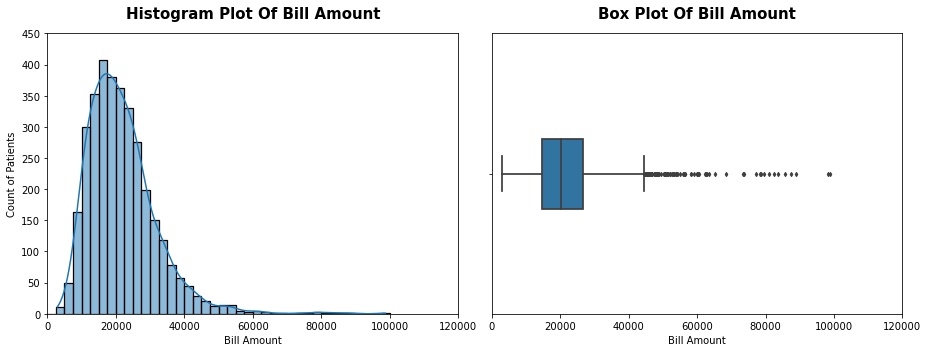

In [88]:
# visualise histogram plot and box plot of bill_amount column
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5), sharex=False, sharey=False)

title_kws = {'pad': 15, 'fontweight': 'bold', 'fontsize': 15}

sns.histplot(
    data=df,
    x='bill_amount',
    binwidth=2500,
    binrange=(0, 100000),
    kde=True,
    linewidth=1.25,
    ax=ax[0],
)

ax[0].set_title('Histogram Plot Of Bill Amount', **title_kws)
ax[0].set_ylabel('Count of Patients')
ax[0].set_xlabel('Bill Amount')
ax[0].set_ylim(0, 450)
ax[0].set_xlim(0, 120000)

sns.boxplot(
    data=df,
    x='bill_amount',
    orient='h',
    width=0.25,
    linewidth=1.75,
    fliersize=3,
    ax=ax[1],
)

ax[1].set_title('Box Plot Of Bill Amount', **title_kws)
ax[1].set_xlabel('Bill Amount')
ax[1].set_xlim(0, 120000)

fig.tight_layout()

fig.savefig(plots_dir.joinpath('target_bill_amount.png'), bbox_inches='tight', transparent=True)

**Interpretation:** The histogram plot of bill amount shows that the distribution is asymmetrical with a positive or right skew. Most of the values are clustered to the left which forms the body of the distribution. The most frequent bill amount seen is around $20,000. There are a few extreme values to the right which forms the tail of the distribution. There are several patients who have extremely large bill amounts. This is confirmed by the box plot of bill amount which shows there are outliers with extremely high target values. In order to reduce the skew in the target variable and make it assume a more normal distribution, it will be log transformed to see if it will improve the performance of the regression model later on.

In [89]:
# log transform bill_amount column
df['log_bill_amount'] = np.log(df['bill_amount'])
df[['bill_amount', 'log_bill_amount']].head(1)

,bill_amount,log_bill_amount
0,15405.418665,9.642475


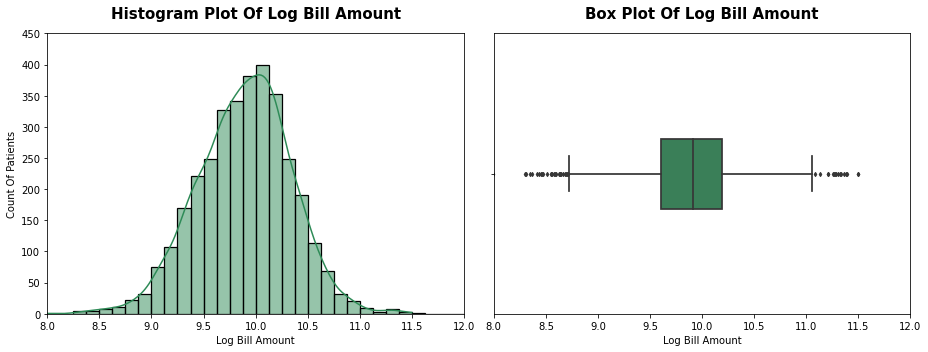

In [90]:
# visualise histogram plot and box plot of log_bill_amount column
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5), sharex=False, sharey=False)

title_kws = {'pad': 15, 'fontweight': 'bold', 'fontsize': 15}

sns.histplot(
    data=df,
    x='log_bill_amount',
    binwidth=0.125,
    binrange=(7, 12),
    kde=True,
    linewidth=1.25,
    ax=ax[0],
    color='seagreen',
)
ax[0].set_title('Histogram Plot Of Log Bill Amount', **title_kws)
ax[0].set_ylabel('Count Of Patients')
ax[0].set_xlabel('Log Bill Amount')
ax[0].set_ylim(0, 450)
ax[0].set_xlim(8, 12)

sns.boxplot(
    data=df,
    x='log_bill_amount',
    orient='h',
    width=0.25,
    linewidth=1.75,
    fliersize=3,
    ax=ax[1],
    color='seagreen',
)
ax[1].set_title('Box Plot Of Log Bill Amount', **title_kws)
ax[1].set_xlabel('Log Bill Amount')
ax[1].set_xlim(8, 12)

fig.tight_layout()

fig.savefig(plots_dir.joinpath('target_log_bill_amount.png'), bbox_inches='tight', transparent=True)

**Interpretation:** After log transformation of the target variable, the histogram plot of log bill amount shows a distribution that is more symmetrical with less positive or right skew. This is verified by the box plot of bill amount which shows there are fewer outliers with extremely high target values.

### Categorical Feature & Categorical Feature-Target Visualisations

In [91]:
# define function to visualise count plot of categorical feature,
# as well as box plot and bar plot of categorical feature against target

def plot_categorical(df, features, palette='winter'):

    fig, ax = plt.subplots(nrows=len(features), ncols=3, figsize=(15, len(features)*5), sharex=False, sharey=False)
    ax = ax.ravel()
    
    title_kws = {'pad': 12, 'fontweight': 'bold', 'fontsize': 12}

    for i, feature in enumerate(features):

        feature_name = feature.replace('_', ' ').title()

        sns.countplot(
            data=df,
            x=feature, 
            order=np.sort(df[feature].unique()),
            linewidth=1.25,
            ax=ax[i*3],
            palette=palette,
        )

        ax[i*3].set_title(f'Count Plot Of \n {feature_name}', **title_kws)
        ax[i*3].set_ylabel('Count Of Patients')
        ax[i*3].set_xlabel(feature_name)

        sns.boxplot(
            data=df,
            x=feature,
            y='bill_amount',
            order=np.sort(df[feature].unique()),
            width=0.5,
            linewidth=1.75,
            ax=ax[i*3+1],
            palette=palette,
        )

        ax[i*3+1].set_title(f'Box Plot Of Bill Amount By \n {feature_name}', **title_kws)
        ax[i*3+1].set_ylabel('Bill Amount')
        ax[i*3+1].set_xlabel(feature_name)

        sns.barplot(
            data=df,
            x=feature,
            y='bill_amount',
            order=np.sort(df[feature].unique()),
            ax=ax[i*3+2],
            palette=palette,
        )

        ax[i*3+2].set_title(f'Bar Plot Of Mean Bill Amount By \n {feature_name}', **title_kws)
        ax[i*3+2].set_ylabel('Mean Bill Amount')
        ax[i*3+2].set_xlabel(feature_name)

    fig.tight_layout()

    fig_name = '_'.join(features)
    fig.savefig(plots_dir.joinpath(f'categorical_feature_{fig_name}.png'), bbox_inches='tight', transparent=True)

#### Gender | Race | Resident Status

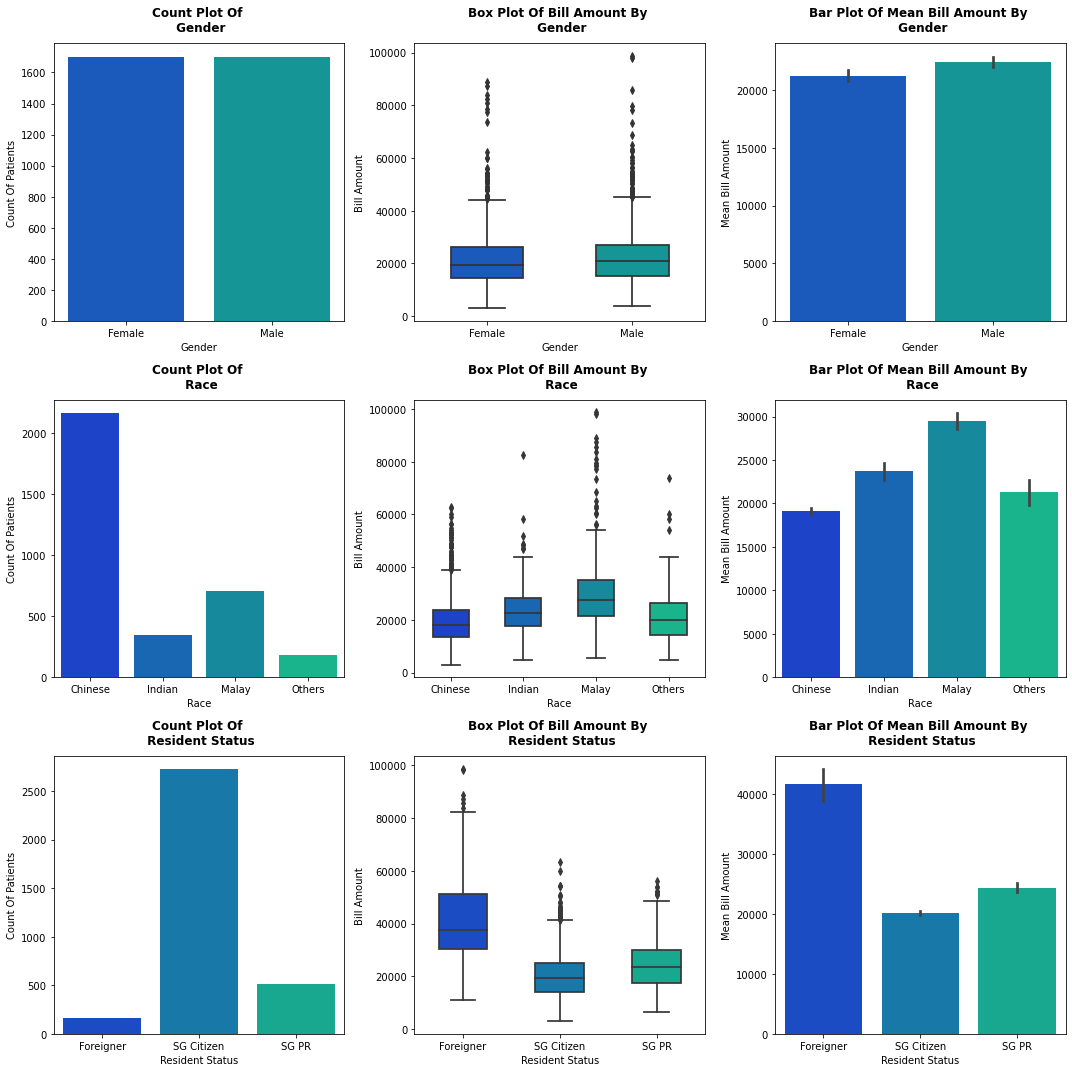

In [92]:
# visualise plots for gender, race, and resident_status columns
features = ['gender', 'race', 'resident_status']
plot_categorical(df, features)

**Interpretation:**

1. Gender

There is an approximately equal number of male and female patients in the dataset. Neither gender is under- or over-represented here. Male patients have slightly higher median and mean bill amounts than female patients.

2. Race

Chinese form the majority of patients in the dataset, followed by Malays, Indians, and Others. The racial composition is more or less representative of the ethnic makeup in Singapore. Among all the races, Malay patients have the highest median and mean bill amounts whereas Chinese patients have the lowest.

3. Resident Status

Singapore Citizens form the majority of patients in the dataset, followed by Singapore Permanent Residents, and then Foreigners. The resident proportions are roughly similar to the population census figures of Singapore. Among all the groups, Foreigners have the highest median and mean bill amounts, followed by Singapore Permanent Residents, and then Singapore Citizens. This order is not surprising as Foreigners do not get bill subsidies when they seek medical treatment in Singapore while Singapore Permanent Residents get lower bill subsidies than Singapore Citizens.

#### Year Of Admission | Month Of Admission

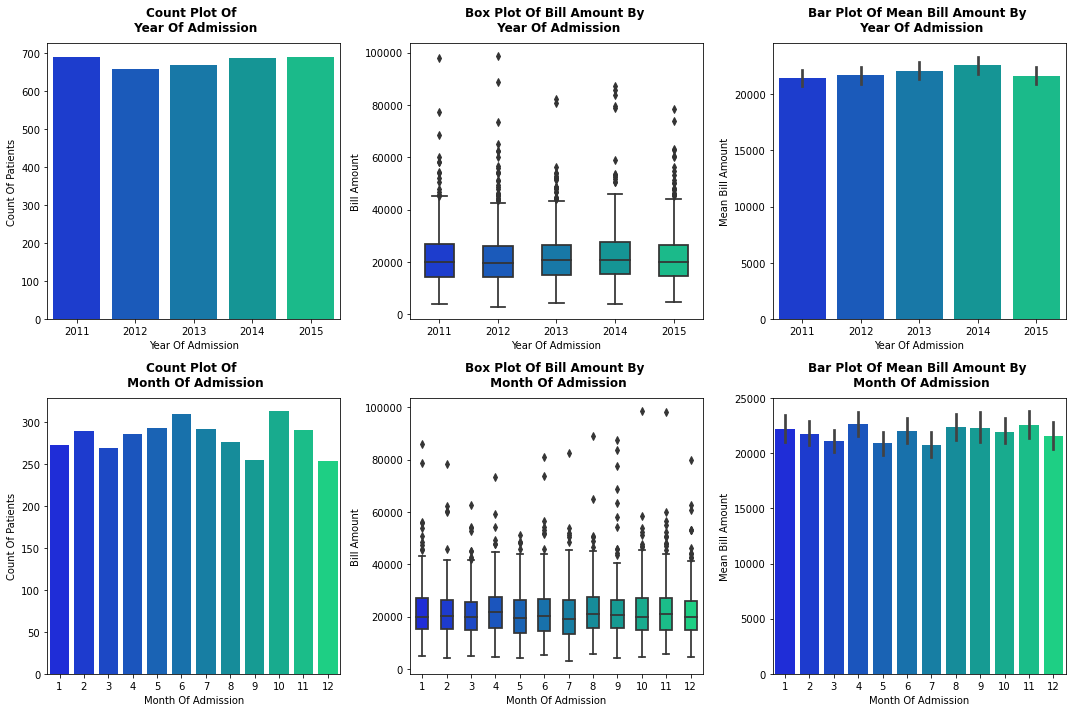

In [93]:
# visualise plots for year_of_admission and month_of_admission columns
features = ['year_of_admission', 'month_of_admission']
plot_categorical(df, features)

**Interpretation:**

1. Year Of Admission

The dataset contains an approximate equal number of patient admissions every year from 2011 to 2015. There seems to be no relationship between the year of admission and the bill amount. In fact, the median and mean bill amounts have stayed uniform across all years. Hence, year of admission will be eliminated as a feature.

2. Month Of Admission

The number of patient admissions changes marginally from month to month. It appears that September and December have relatively low patient loads whereas June and October have relatively higher patient loads. Likewise, there seems to be no relationship between the month of admission and the bill amount. The median and mean bill amounts do not seem to follow any trend across all months. Hence, month of admission will be eliminated as a feature.

#### Hospitalisation Count

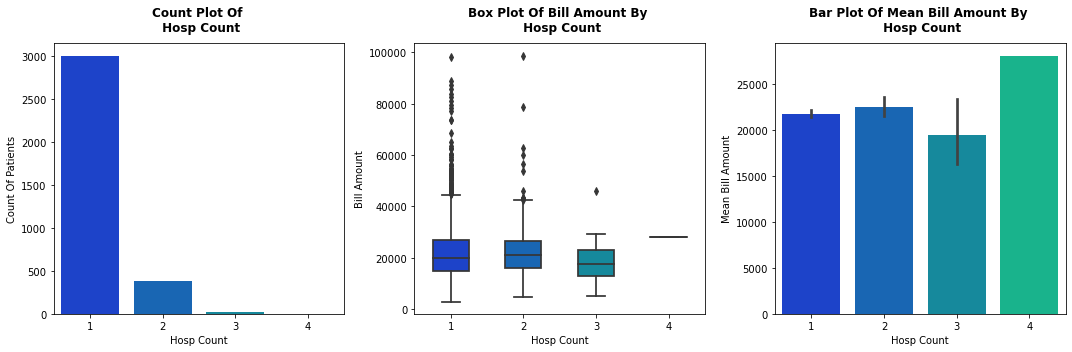

In [94]:
# visualise plots for hosp_count column
features = ['hosp_count']
plot_categorical(df, features)

**Interpretation:** 

1. Hospitalisation Count

The vast majority of patients have been admitted to the hospital only once. There are a few patients who have been in and out of the hospital twice, thrice, and 4 times. At first, the rationale behind this feature was to determine if there was a relationship between subsequent admissions and bill amounts. Although the median and mean bill amounts appear to increase as hospitalisation count increases, it should be noted that the hospitalisation count of 4 has only 1 patient in it. Hence, it is difficult to conclude if this relationship holds true given that the dataset does not contain enough data on patients who have had multiple admissions and is comprised mainly of patients who have had 1 admission. Due to its low variation, hospitalisation count will be eliminated as a feature.

#### Medical History 1-7 | Number Of Medical Histories

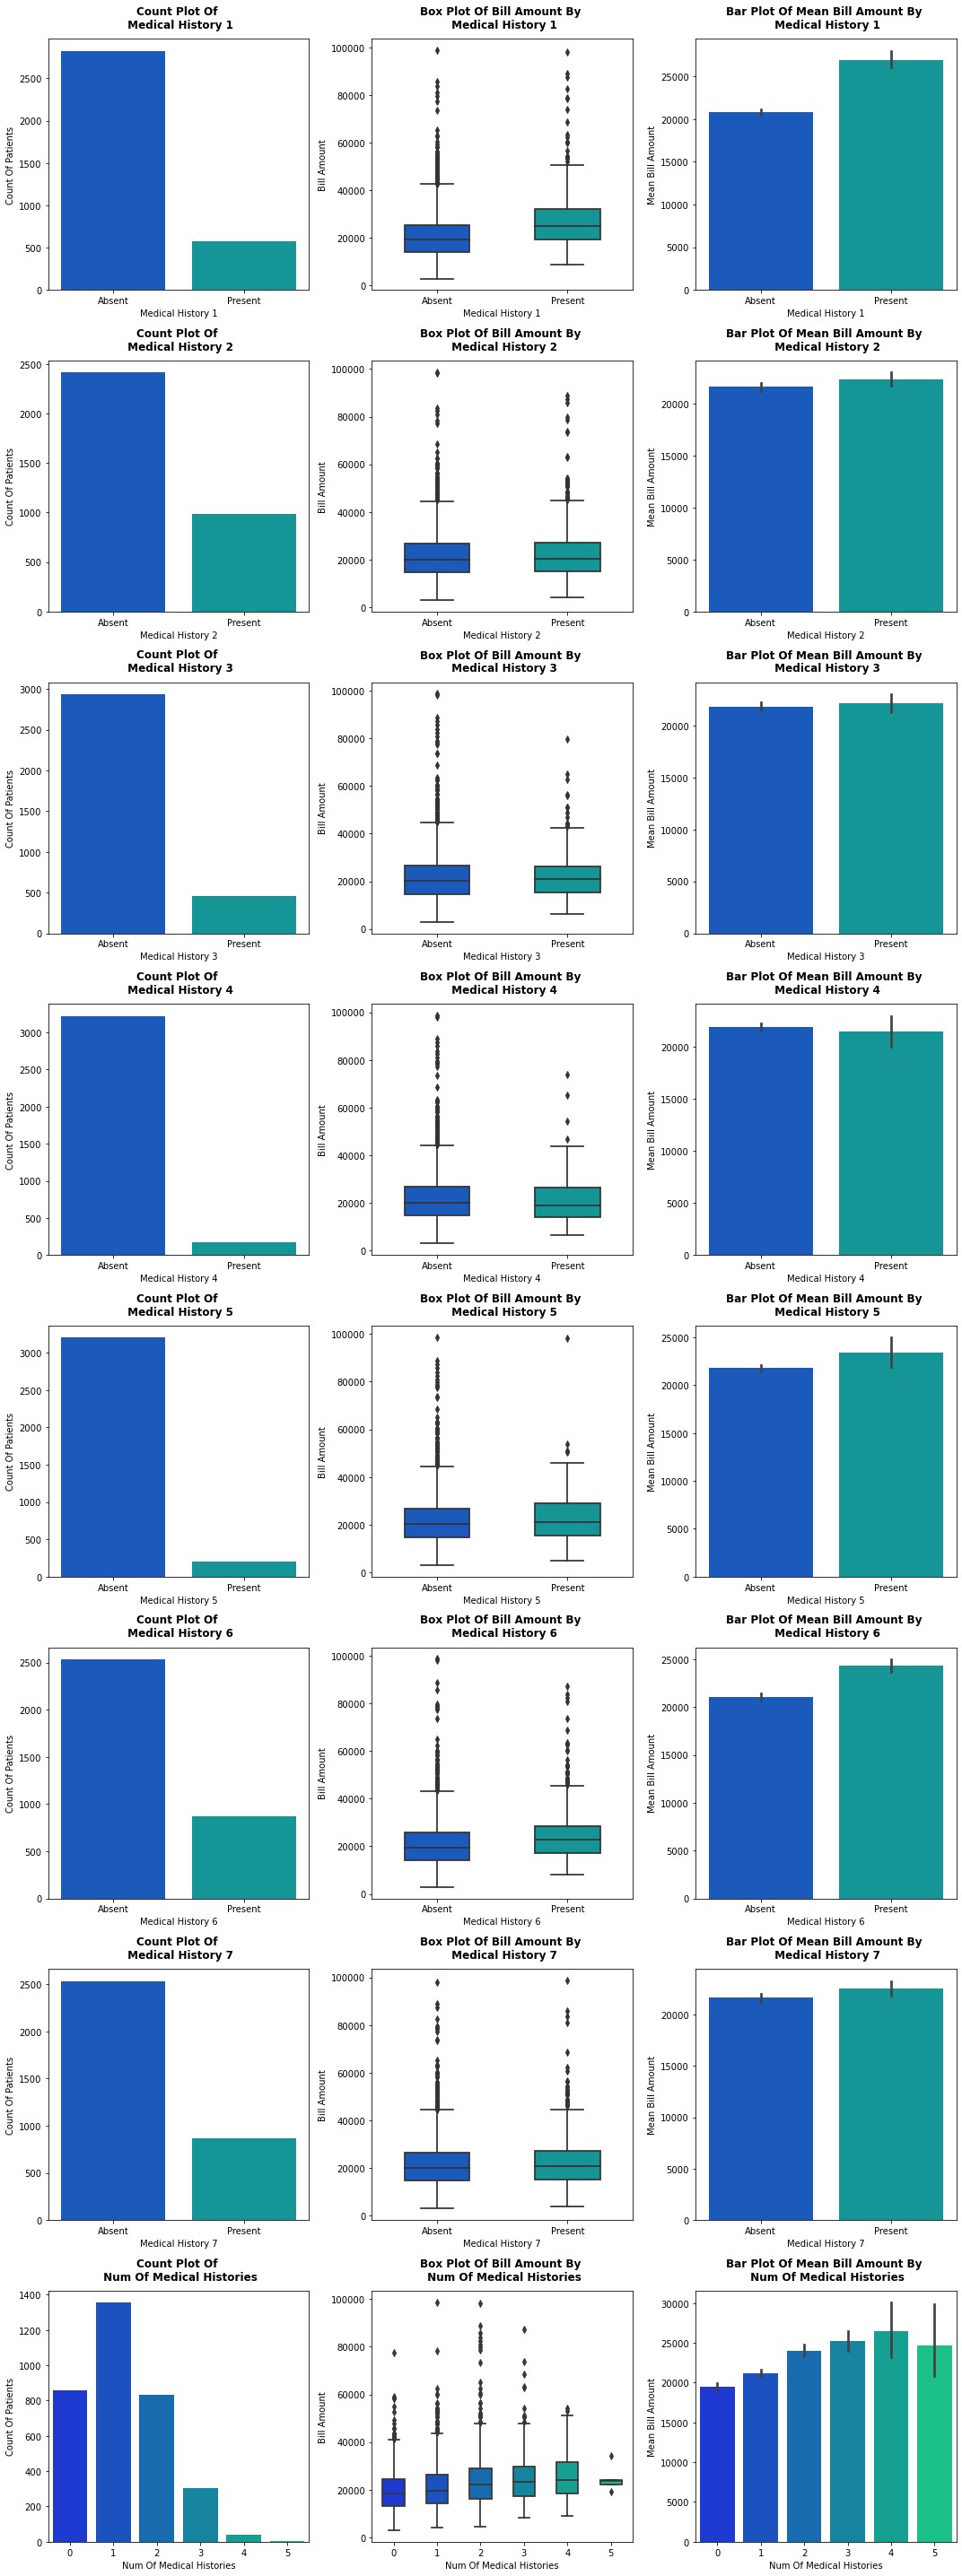

In [95]:
# visualise plots for all medical_history columns and the num_of_medical_histories column
features = [
    'medical_history_1',
    'medical_history_2',
    'medical_history_3',
    'medical_history_4',
    'medical_history_5',
    'medical_history_6',
    'medical_history_7',
    'num_of_medical_histories',
]
plot_categorical(df, features)

**Interpretation:**

1. Medical History 1-7

For each medical history, there are more patients who do not have it than those who do. In all medical histories except `medical_history_4`, patients who have that medical history have higher median and mean bill amounts than patients who do not. In particular, patients with `medical_history_1` or `medical_history_6` pay considerably higher bills than patients without them, which could suggest them to be debilitating conditions that require extensive treatment and expensive medications. Quite surprisingly, patients who have `medical_history_4` have lower bills than patients who do not, which could suggest them to be childhood conditions since these are unlikely to require any treatment during the hospitalisation.

2. Number Of Medical Histories

Patients with 1 medical history are the most common in the dataset. There appears to be a subtle positive relationship between the number of medical histories and the bill amount. As the number of medical histories increases, the median and mean bill amounts increase. This makes logical sense as patients who have more comorbidities will need more care during their hospitalisation and can be expected to rack up a larger bill.

#### Pre-Op Medication 1-6 | Number Of Pre-Op Medications

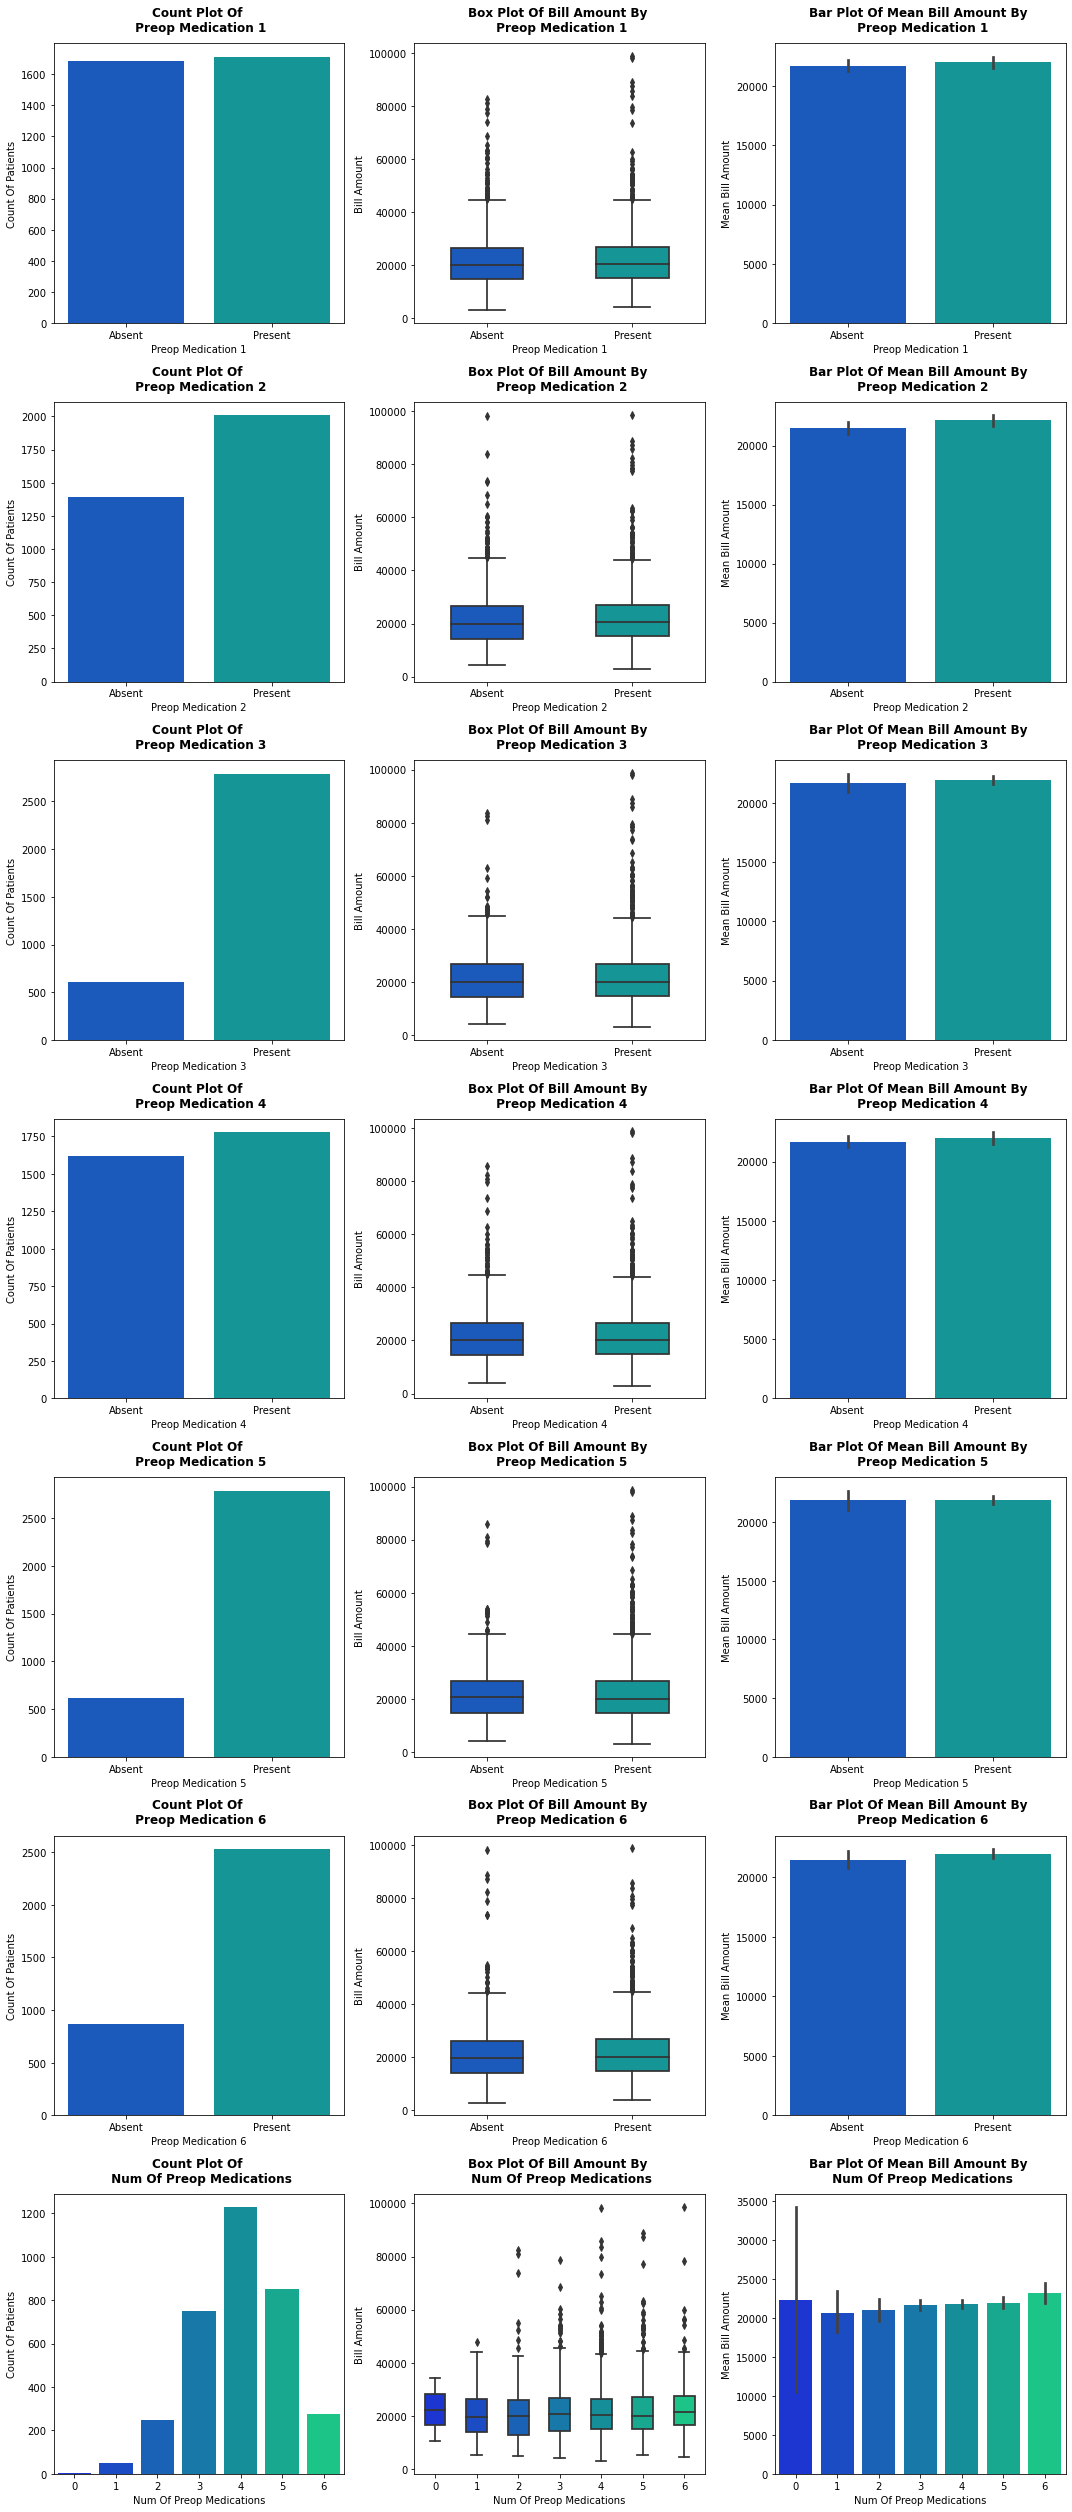

In [96]:
# visualise plots for all preop_medication columns and the num_of_preop_medications column
features = [
    'preop_medication_1',
    'preop_medication_2',
    'preop_medication_3',
    'preop_medication_4',
    'preop_medication_5',
    'preop_medication_6',
    'num_of_preop_medications',
]
plot_categorical(df, features)

**Interpretation:**

1. Pre-Op Medication 1-6

About half of the patients received `preop_medication_1` or `preop_medication_4` and about half did not. More patients received `preop_medication_2`, `preop_medication_3`, `preop_medication_5`, or `preop_medication_6` than patients who did not. For each pre-op medication, the median and mean bill amounts for patients who received that pre-op medication are roughly the same as that of patients who did not. This could be because the drug is cheap or because only 1 dose is needed before the operation. Individually, they do not seem to affect the bill amount significantly. As such, `preop_medication_1` to `preop_medication_6` will be eliminated as features.

2. Number Of Pre-Op Medications

The most common number of pre-op medications received by patients in the dataset is 4. The median bill amounts across the different number of pre-op medications appear to be relatively uniform. However, the mean bill amounts across the different number of pre-op medications appear to show a slight increasing trend. This could be explained by the many high bill amount outliers for patients who received a large number of pre-op medications. This agrees with common intuition that a greater quantity of medications served would translate into a higher cost of hospitalisation.

#### Symptom 1-5 | Number Of Symptoms

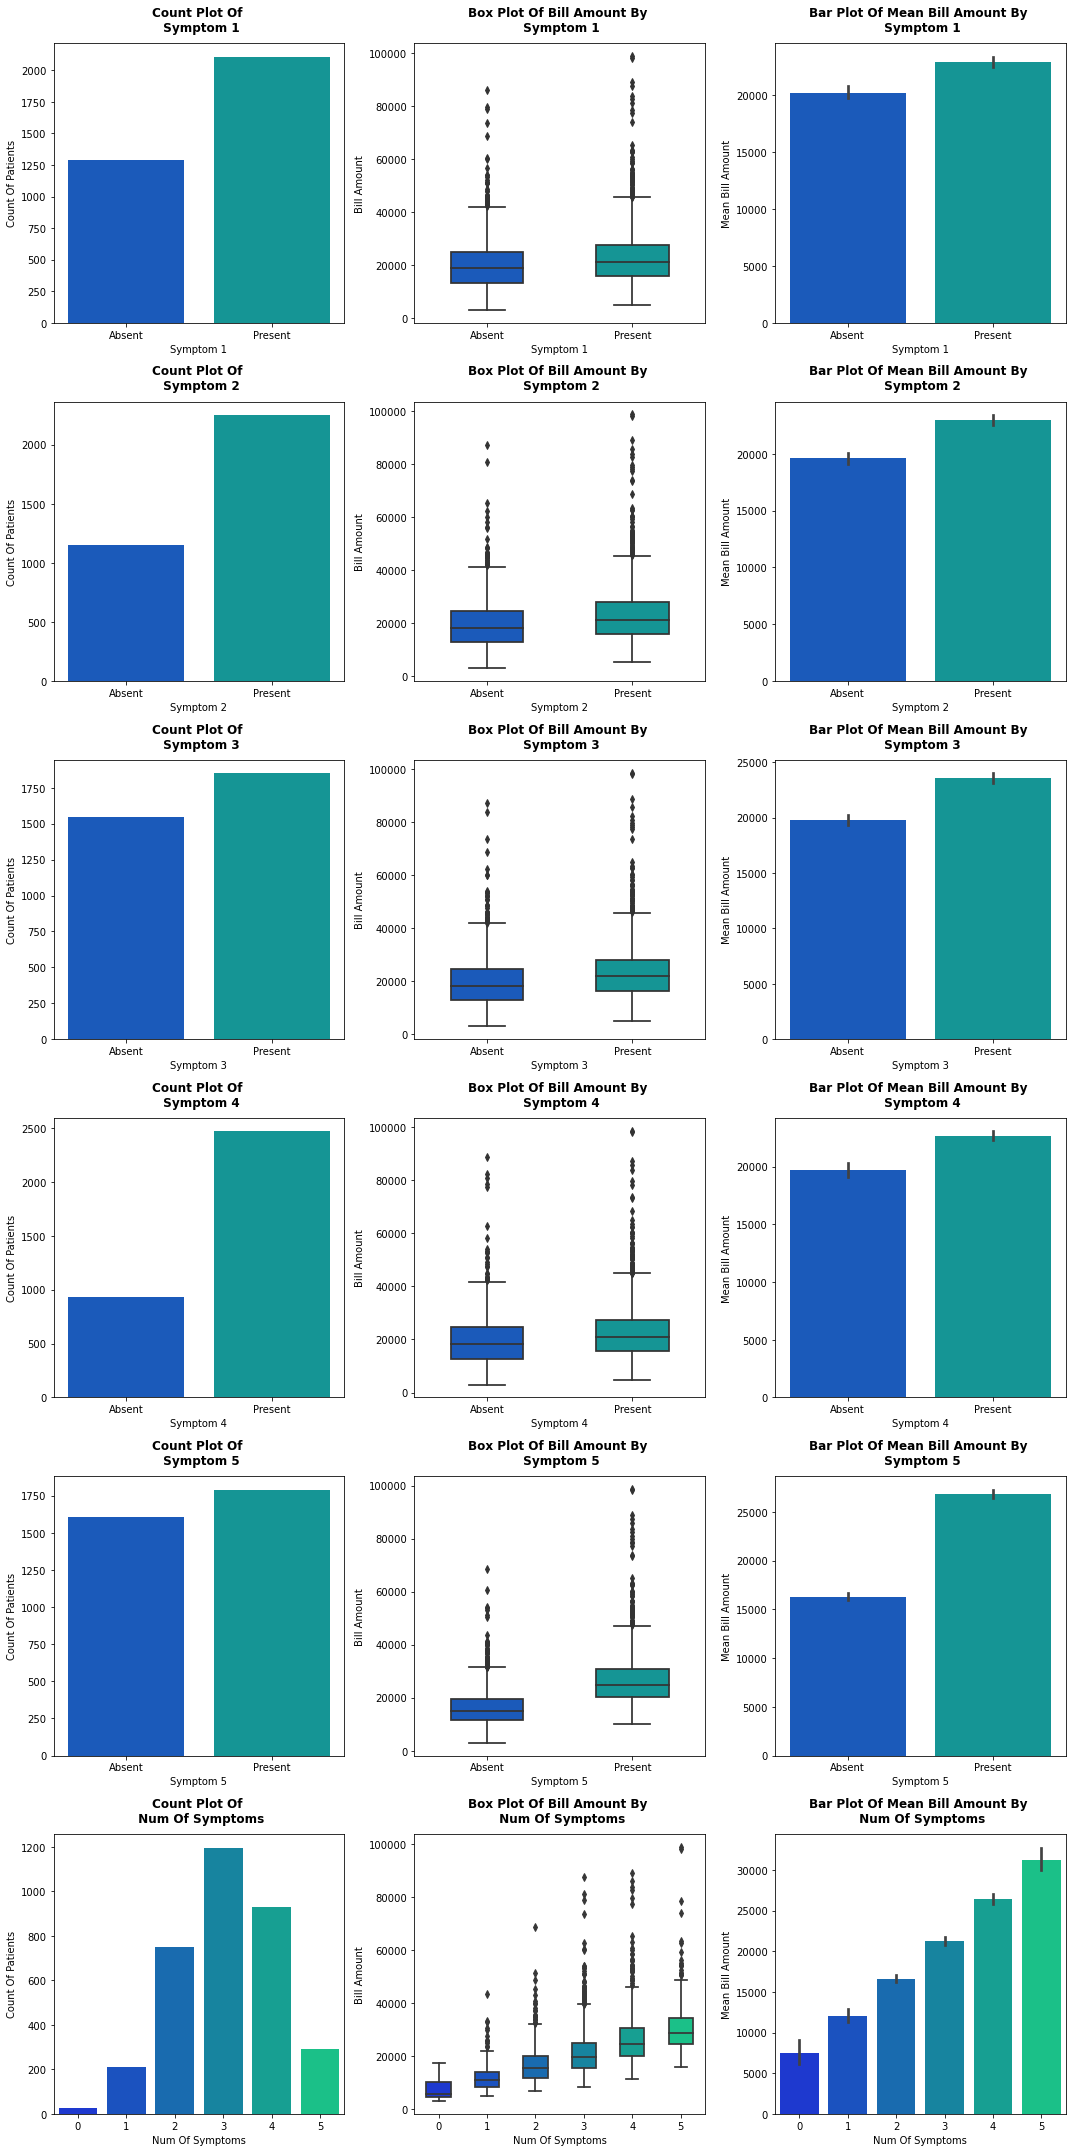

In [97]:
# visualise plots for all symptom columns and the num_of_symptoms column
features = [
    'symptom_1',
    'symptom_2',
    'symptom_3',
    'symptom_4',
    'symptom_5',
    'num_of_symptoms',
]
plot_categorical(df, features)

**Interpretation:**

1. Symptom 1-5

For each symptom, there are more patients who have it than those who do not. Across all symptoms, the median and mean bill amounts of patients who have that symptom are higher than that of patients who do not. It is possible that `symptom_5` is a life-threatening symptom as, when compared to the other symptoms, there are only slightly more patients who have it but the bill amounts for these patients who have it are drastically higher.

2. Number Of Symptoms

Patients with 3 symptoms are the most common in the dataset. There appears to be a strong positive correlation between the number of symptoms and the bill amount. As the number of symptoms increases, the median and mean bill amounts increase. This can be explained by the fact that patients who have more symptoms need more medical attention and would consequently end up with a larger bill.

### Numerical Feature & Numerical Feature-Target Visualisations

In [98]:
# define function to visualise histogram plot and box plot of numerical feature,
# as well as regression plot of numerical feature against target

def plot_numerical(df, features):

    fig, ax = plt.subplots(nrows=len(features), ncols=3, figsize=(15, len(features)*5), sharex=False, sharey=False)
    ax = ax.ravel()
    
    title_kws = {'pad': 12, 'fontweight': 'bold', 'fontsize': 12}

    for i, feature in enumerate(features):
        
        feature_name = feature.replace('_', ' ').title()

        sns.histplot(
            data=df,
            x=feature,
            kde=True,
            linewidth=1.25,
            ax=ax[i*3],
        )

        ax[i*3].set_title(f'Histogram Plot Of \n {feature_name}', **title_kws)
        ax[i*3].set_ylabel('Count Of Patients')
        ax[i*3].set_xlabel(feature_name)

        sns.boxplot(
            data=df,
            x=feature,
            orient='h',
            width=0.25,
            linewidth=1.75,
            fliersize=3,
            ax=ax[i*3+1],
        )

        ax[i*3+1].set_title(f'Box Plot Of \n {feature_name}', **title_kws)
        ax[i*3+1].set_xlabel(feature_name)

        sns.regplot(
            data=df,
            x=feature,
            y='bill_amount',
            scatter_kws={'s': 3, 'alpha': 0.75},
            line_kws={'linewidth': 1.5, 'color': 'black'},
            ax=ax[i*3+2],
        )

        ax[i*3+2].set_title(f'Regression Plot Of Bill Amount Against \n {feature_name}', **title_kws)
        ax[i*3+2].set_ylabel('Bill Amount')
        ax[i*3+2].set_xlabel(feature_name)

    fig.tight_layout()

    fig_name = '_'.join(features)
    fig.savefig(plots_dir.joinpath(f'numerical_feature_{fig_name}.png'), bbox_inches='tight', transparent=True)

#### Weight | Height | Body Mass Index

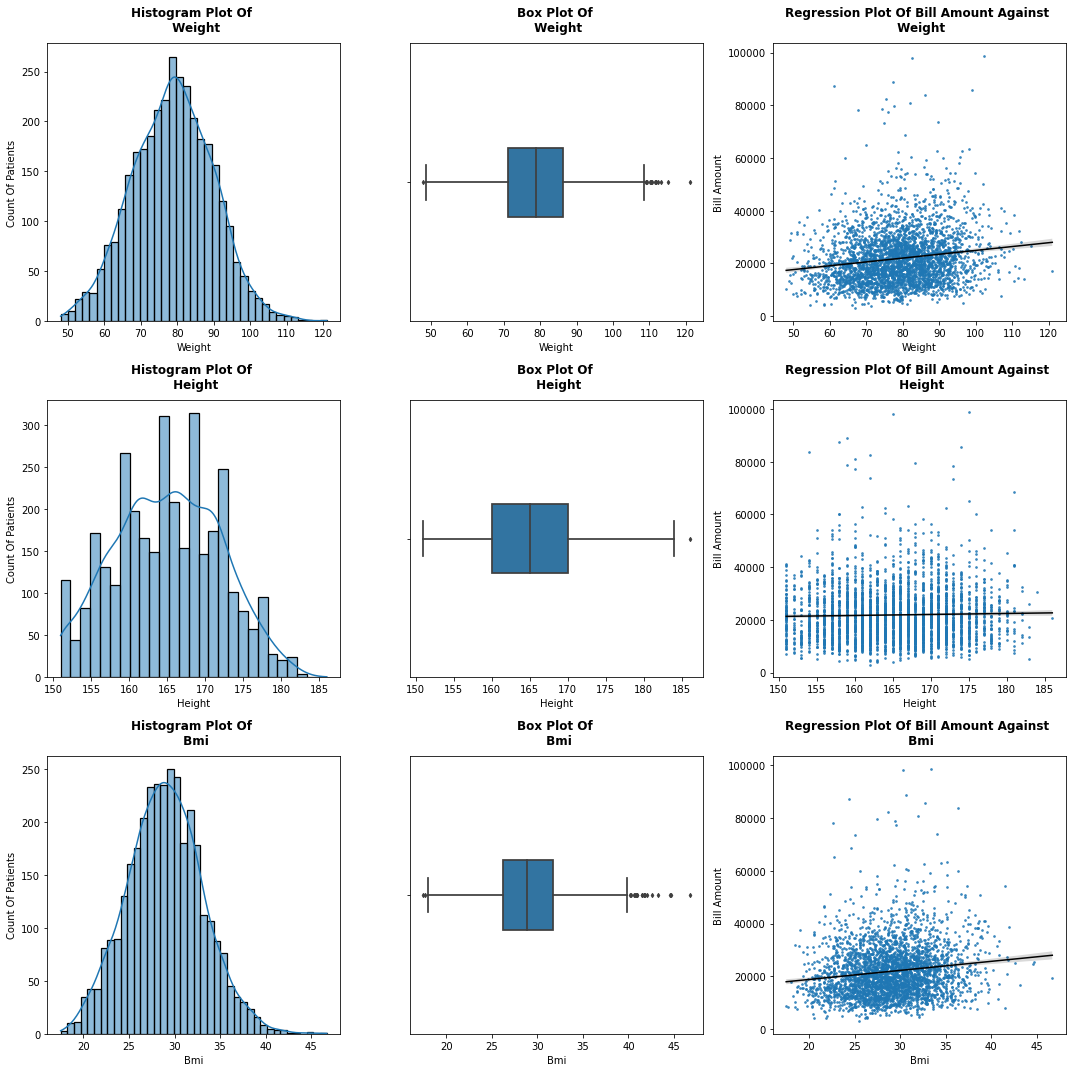

In [99]:
# visualise plots for weight, height, and bmi columns
features = ['weight', 'height', 'bmi']
plot_numerical(df, features)

**Interpretation:**

1. Weight

The weight of patients in the dataset appears to be normally distributed with the peak weight at around 80kg. There are a few outliers to the right that represent patients with extremely heavy weights. Looking at the plot of bill amount against weight, it can be seen that there is a positive correlation between them. This is in line with our understanding that heavier patients tend to be at higher risk for obesity-related diseases, which would contribute to the cost of care during a hospitalisation.

2. Height

The height of patients in the dataset appears to be normally distributed with the peak height at around 165cm. Looking at the plot of bill amount against height, it can be seen that there is no correlation between them. This makes logical sense as height plays little to no role in determining disease occurrences, states, and outcomes. As it will not be useful in predicting bill amount, height will be eliminated as a feature.

3. Body Mass Index

The BMI of patients in the dataset appears to be normally distributed with the peak BMI at around 30kg/m². There are a few outliers to the right that represent patients with extremely large BMIs. Looking at the plot of bill amount against BMI, it can be seen that there is a positive correlation between them. This is in line with our understanding that patients with a higher BMI are going to be more obese and likely to be suffering from obesity-related diseases, which would require a greater degree of care during hospitalisation. Given that a BMI > 25kg/m² indicates over-weight and a BMI > 30kg/m² indicates obese, it should be noted that the vast majority of patients are either over-weight or obese. As such, it would not be unreasonable to assume that the bulk majority of patients is suffering from some form of obesity-related diseases.

#### Age At Admission

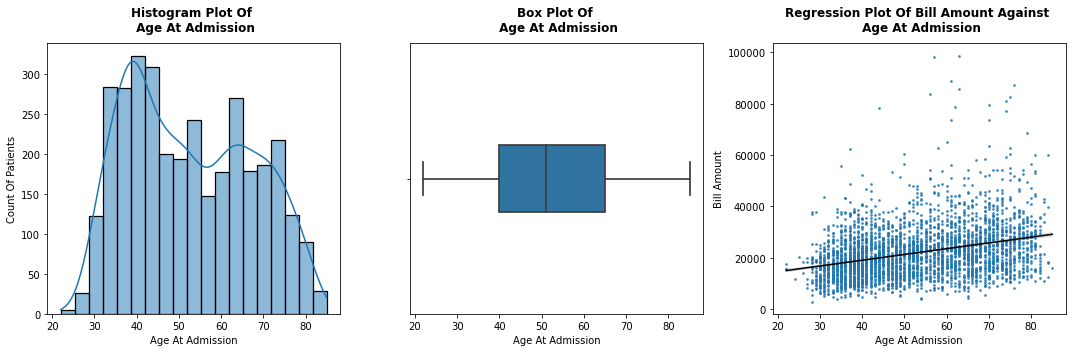

In [100]:
# visualise plots for age_at_admission column
features = ['age_at_admission']
plot_numerical(df, features)

**Interpretation:**

1. Age At Admission

The distribution of age at admission of patients in the dataset appears to have 2 peaks, one at around 40 years and another at around 65 years. A plot of bill amount against age at admission reveals that there is a positive correlation between them. This is expected as with increasing age comes more medical conditions and more expensive hospitalisation bills.

#### Days Hospitalised | Days Since Last Hospitalisation

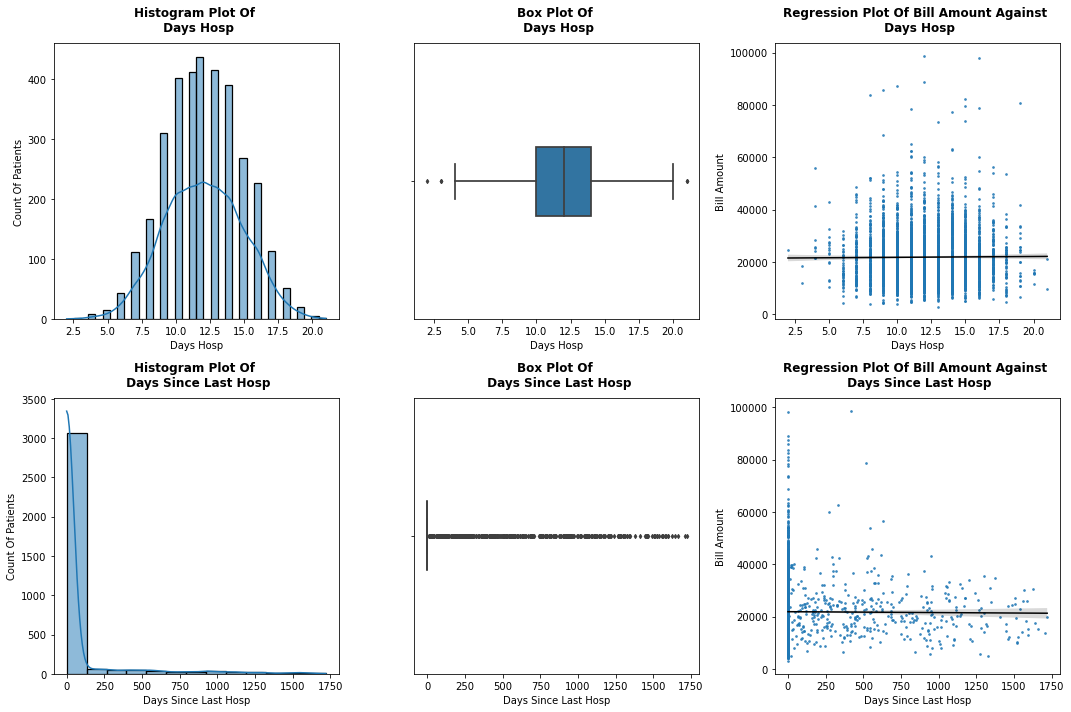

In [101]:
# visualise plots for days_hosp and days_since_last_hosp columns
features = ['days_hosp', 'days_since_last_hosp']
plot_numerical(df, features)

**Interpretation:**

1. Days Hospitalised

The distribution of the number of days hospitalised appears to be normal with the peak at around 12 days. When bill amount is plotted against days hospitalised, there appears to be no correlation between them, which is surprising as one would expect to see bigger hospitalisation bills for patients with longer hospital stays. As it will not be useful in predicting bill amount, days hospitalised will be eliminated as a feature.

2. Days Since Last Hospitalisation

The distribution of the number of days since last hospitalisation is very asymmetrical with an extreme positive or right skew. This is because most of the patients have only 1 admission and thus the number of days since last hospitalisation is predominantly 0. At first, the rationale behind this feature was to determine if there was a relationship between time between admissions and bill amounts. However, the plot of bill amount against days since last hospitalisation shows that they have no correlation. Due to that and its low variation, days since last hospitalisation will be eliminated as a feature.

#### Lab Result 1-3

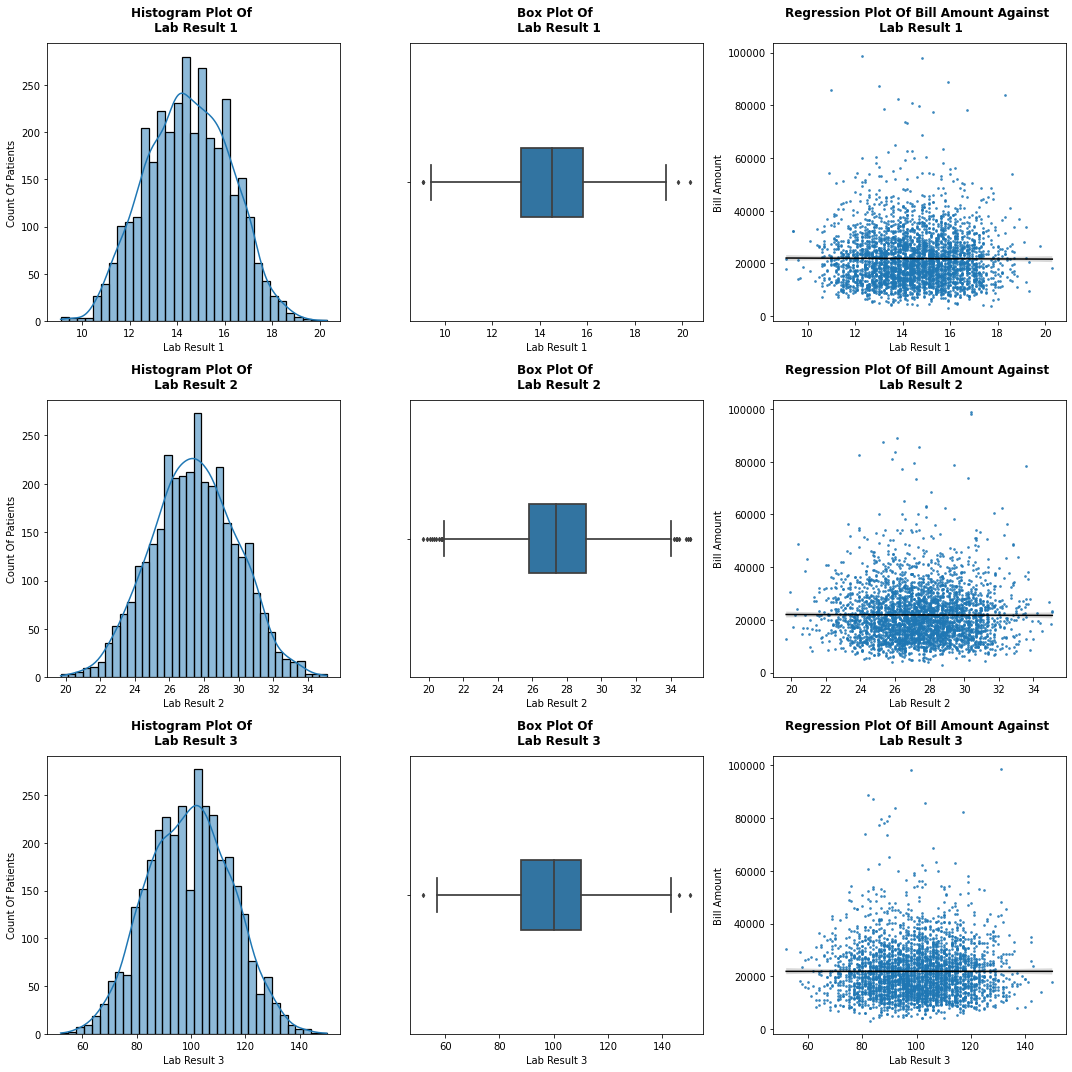

In [102]:
# visualise plots for all lab_result columns
features = ['lab_result_1', 'lab_result_2', 'lab_result_3']
plot_numerical(df, features)

**Interpretation:**

1. Lab Result 1-3

The distribution of each lab result resembles that of a normal distribution with the peak for lab result 1 at around 14, for lab result 2 at around 28, and for lab result 3 at around 105. An examination of the individual plots of bill amount against lab result shows that there is no correlation between them. This is probably expected because it is more useful to know the trend in a patient's lab result over time and see how it relates to bill amount then the patient's lab result at a stationary point in time with respect to the bill amount. Since they have no linear relationship with bill amount, lab result 1-3 will be eliminated as features.

### Numerical Feature-Target Correlation Heatmap

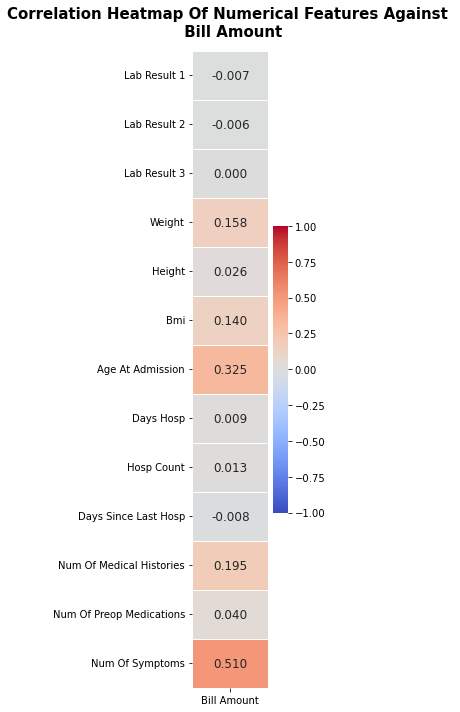

In [103]:
# visualise correlation heatmap of numerical features against bill amount
# to check which numerical features have a low correlation with the target
# in order to assist with feature selection and elimination
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 10), sharex=False, sharey=False)

title_kws = {'pad': 15, 'fontweight': 'bold', 'fontsize': 15}

df_temp = df.copy()
df_temp = df_temp.rename(columns=(lambda x: x.replace('_', ' ').title()))
df_temp = df_temp.corr()
df_temp = df_temp.iloc[:-2, -2].to_frame()

sns.heatmap(
    df_temp,
    linewidths=1,
    annot=True,
    annot_kws={'fontsize': 12},
    fmt='.3f',
    vmin=-1,
    vmax=1,
    ax=ax,
    cmap='coolwarm',
)

ax.set_title('Correlation Heatmap Of Numerical Features Against \n Bill Amount', **title_kws)

fig.tight_layout()

fig.savefig(plots_dir.joinpath('heatmap_numerical_feature_target.png'), bbox_inches='tight', transparent=True)

**Interpretation:** 

In a linear regression, we want to eliminate the features that are weakly correlated with the target to improve linearity.

The numerical features which are weakly correlated with the target (absolute correlation coefficient < 0.1) include:
- `lab_result_1`
- `lab_result_2`
- `lab_result_3`
- `height`
- `days_hosp`
- `hosp_count`
- `days_since_last_hosp`
- `num_of_preop_medications`

The results are in agreement with the inferences drawn during the interpretation of the visualisations. Within this set of numerical features, the decision has been made previously to drop all of them except for `num_of_preop_medications`. However, seeing as how `num_of_preop_medications` has a correlation coefficient of only 0.040 with bill amount, the decision here will also be to eliminate it as a feature.

### Numerical Feature-Numerical Feature Correlation Heatmap

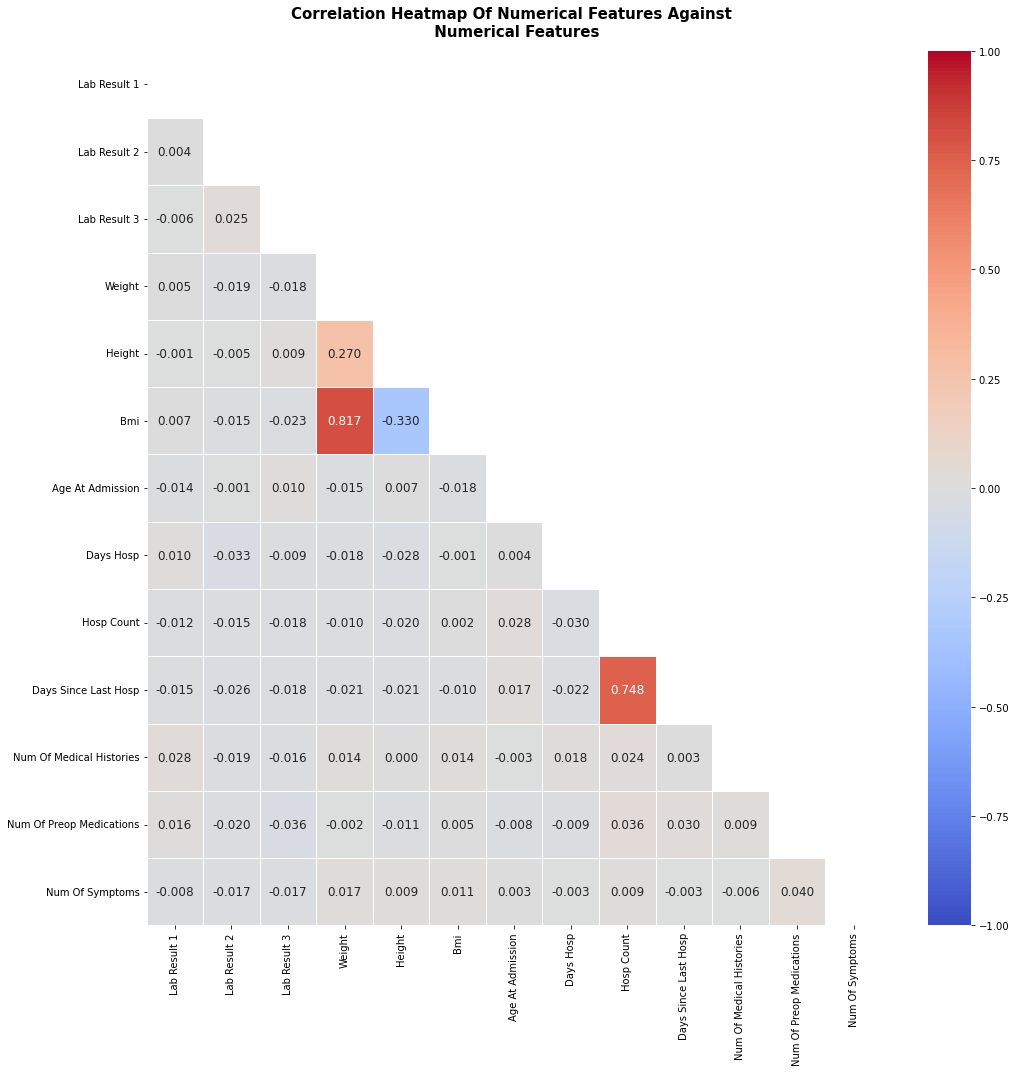

In [104]:
# visualise correlation heatmap of numerical features against numerical features
# to check which pairs of numerical features have a high correlation with each other
# in order to assist with feature selection and elimination
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15), sharex=False, sharey=False)

title_kws = {'pad': 15, 'fontweight': 'bold', 'fontsize': 15}

mask = np.zeros_like(df.drop(columns=['bill_amount', 'log_bill_amount']).corr())
mask[np.triu_indices_from(mask)] = True

df_temp = df.copy()
df_temp = df_temp.drop(columns=['bill_amount', 'log_bill_amount'])
df_temp = df_temp.rename(columns=(lambda x: x.replace('_', ' ').title()))
df_temp = df_temp.corr()

sns.heatmap(
    df_temp,
    linewidths=1,
    annot=True,
    annot_kws={'fontsize': 12},
    fmt='.3f',
    vmin=-1,
    vmax=1,
    mask=mask,
    ax=ax,
    cmap='coolwarm',
)

ax.set_title('Correlation Heatmap Of Numerical Features Against \n Numerical Features', **title_kws)

fig.tight_layout()

fig.savefig(plots_dir.joinpath('heatmap_numerical_feature_numerical_feature.png'), bbox_inches='tight', transparent=True)

**Interpretation:** 

In a linear regression, we want to eliminate pairs of features that are strongly correlated with each other to reduce multicollinearity.

The pairs of numerical features which are strongly correlated with each other (absolute correlation coefficient > 0.7) include:

- `hosp_count` and `days_since_last_hosp`
- `weight` and `bmi`

Given that `hosp_count` and `days_since_last_hosp` are already going to be dropped, they will be ignored in this discussion. Since `weight` and `bmi` have a strong pairwise correlation coefficient of 0.817, it would be prudent to drop 1 of them. Against `bill_amount`, `weight` and `bmi` have a correlation coefficient of 0.158 and 0.140 respectively. As `bmi` has a lower correlation with `bill_amount`, the decision will be made to eliminate it as a feature.

## Pre-Processing & Modelling

### Feature Selection & Elimination

In [105]:
# eliminate features that have not been selected
df = df.drop(columns=[
    'year_of_admission',
    'month_of_admission',
    'preop_medication_1',
    'preop_medication_2',
    'preop_medication_3',
    'preop_medication_4',
    'preop_medication_5',
    'preop_medication_6',
    'lab_result_1',
    'lab_result_2',
    'lab_result_3',
    'height',
    'bmi',
    'days_hosp',
    'hosp_count',
    'days_since_last_hosp',
    'num_of_preop_medications',
])

### Data Exporting III

In [106]:
# undo mapping for these 3 columns: medical_history, preop_medication, symptom
# to facilitate pre-processing and modelling
num_to_cat = df.loc[:, 'medical_history_1': 'symptom_5'].columns
for col in num_to_cat:
    df[col] = df[col].map({'Absent': 0, 'Present': 1})

In [107]:
# check out head
df.head()

,gender,race,resident_status,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,weight,age_at_admission,num_of_medical_histories,num_of_symptoms,bill_amount,log_bill_amount
0,Male,Indian,SG Citizen,0,1,0,0,0,0,0,0,0,0,1,1,71.3,34,1,2,15405.418665,9.642475
1,Female,Malay,SG Citizen,0,0,0,0,0,0,0,0,0,1,1,1,78.4,32,0,3,23303.000924,10.056337
2,Female,Indian,SG Citizen,0,0,0,0,0,0,0,1,1,1,1,0,72.0,43,0,4,16813.123088,9.729915
3,Female,Chinese,SG PR,0,1,0,0,0,1,1,1,1,1,1,1,64.4,43,3,5,27994.878530,10.239777
4,Female,Others,SG PR,0,0,0,0,0,1,1,0,1,0,1,0,55.6,28,2,2,10707.950907,9.278742


In [108]:
# check out shape
df.shape

(3400, 21)

In [109]:
# export dataframe
df.to_csv(data_dir.joinpath('health_selected.csv'), index=False)

### Data Warehouse

A list of the datasets that have been exported is given below:

* [`health_cleaned.csv`](../data/health_cleaned.csv): Health Dataset Cleaned
* [`health_engineered.csv`](../data/health_engineered.csv): Health Dataset Engineered
* [`health_selected.csv`](../data/health_selected.csv): Health Dataset Selected

### Definition Of Target & Features

In [110]:
# define target
y = df[['bill_amount', 'log_bill_amount']]

In [111]:
# define features
X = df.drop(columns=['bill_amount', 'log_bill_amount'])

### Feature One-Hot Encoding

In [112]:
# one-hot encode categorical features

# dummify gender (use female as baseline category)
X = pd.get_dummies(X, columns=['gender']).drop(columns='gender_Female')

# dummify race (use chinese as baseline category)
X = pd.get_dummies(X, columns=['race']).drop(columns='race_Chinese')

# dummify resident status (use sg citizen as baseline category)
X = pd.get_dummies(X, columns=['resident_status']).drop(columns='resident_status_SG Citizen')

### Train Test Split

In [113]:
# perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [114]:
# divide targets

# bill_amount
y1_train = y_train['bill_amount']
y1_test = y_test['bill_amount']

# log_bill_amount
y2_train = y_train['log_bill_amount']
y2_test = y_test['log_bill_amount']

### Feature Scaling

In [115]:
# scale all features
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

### Model Comparison & Evaluation

The 3 regression models chosen are:
- Linear Regression
- Ridge Regression
- Lasso Regression

The 2 evaluation metrics used will be:
- Coefficient Of Determination (R²)
- Root Mean Squared Error (RMSE)

The 2 targets that will be modelled against are:
- `bill_amount`
- `log_bill_amount`

The modelling process will cover these steps:
- Fitting model
- Making predictions with model
- Scoring model with metrics
- Consolidating results across models

The best performing model on the better predicting target will be selected to train on the entire dataset to produce a final model for analysis.

In [116]:
# create results dataframe
results = pd.DataFrame(columns=[
    'Model',
    'Target',
    'Train R²',
    'Test R²',
    'R² Difference',
    'Train RMSE',
    'Test RMSE',
    'RMSE Difference',
])

In [117]:
# create models list
models = [LinearRegression(), RidgeCV(cv=3), LassoCV(cv=3)]

In [118]:
# create targets list
targets = ['bill_amount', 'log_bill_amount']

In [119]:
# fit and score each model
for model in models:

    for target in targets:

        if target == 'bill_amount':

            model = model.fit(Z_train, y1_train)
            y_pred_train = model.predict(Z_train)
            y_pred_test = model.predict(Z_test)

            r2_train = r2_score(y1_train, y_pred_train)
            r2_test = r2_score(y1_test, y_pred_test)
            r2_diff = r2_test - r2_train

            rmse_train = mean_squared_error(y1_train, y_pred_train, squared=False)
            rmse_test = mean_squared_error(y1_test, y_pred_test, squared=False)
            rmse_diff = rmse_test - rmse_train

        else:

            model = model.fit(Z_train, y2_train)
            y_pred_train = model.predict(Z_train)
            y_pred_test = model.predict(Z_test)
            
            r2_train = r2_score(np.exp(y2_train), np.exp(y_pred_train))
            r2_test = r2_score(np.exp(y2_test), np.exp(y_pred_test))
            r2_diff = r2_test - r2_train

            rmse_train = mean_squared_error(np.exp(y2_train), np.exp(y_pred_train), squared=False)
            rmse_test = mean_squared_error(np.exp(y2_test), np.exp(y_pred_test), squared=False)
            rmse_diff = rmse_test - rmse_train
        
        scores = pd.DataFrame(
            {
                'Model': [model.__class__.__name__],
                'Target': [target],
                'Train R²': [f'{r2_train:.3f}'],
                'Test R²': [f'{r2_test:.3f}'],
                'R² Difference': [f'{r2_diff:.3f}'],
                'Train RMSE': [f'{rmse_train:.3f}'],
                'Test RMSE': [f'{rmse_test:.3f}'],
                'RMSE Difference': [f'{rmse_diff:.3f}'],
            })
        results = pd.concat((results, scores))

results.reset_index(drop=True, inplace=True)
results

,Model,Target,Train R²,Test R²,R² Difference,Train RMSE,Test RMSE,RMSE Difference
0,LinearRegression,bill_amount,0.929,0.921,-0.008,2674.948,2934.107,259.159
1,LinearRegression,log_bill_amount,0.973,0.973,-0.000,1633.142,1700.389,67.246
2,RidgeCV,bill_amount,0.929,0.921,-0.008,2674.312,2929.862,255.550
3,RidgeCV,log_bill_amount,0.973,0.973,-0.000,1639.241,1713.660,74.420
4,LassoCV,bill_amount,0.929,0.921,-0.008,2674.413,2931.671,257.259
5,LassoCV,log_bill_amount,0.974,0.973,-0.000,1628.886,1702.975,74.089


**Verdict:**

Metrics

> R² is a metric that ranges from 0 to 1. The closer it is to 1, the better. It measures how much of the total variability of the dataset can be explained by the regression model. It is a measure of the goodness-of-fit of the regression model.

> RMSE is a metric that ranges from 0 to ∞. The closer it is to 0, the better. It is obtained by taking the square root of the average of the squared difference between the expected target values and predicted target values in the dataset. It measures the standard deviation of the residuals in the dataset.

Discussion

> When predicting `bill_amount`, all 3 regression models performed well and similarly to one another when evaluated using R² and RMSE. There is some slight overfitting across the board as can be seen from the lower test R² vs train R² and the higher test RMSE vs train RMSE.

> When predicting `log_bill_amount`, all 3 regression models performed well and similarly to one another when evaluated using R² and RMSE, though the scores are generally better compared to that of `bill_amount`. There is some slight overfitting across the board as can be seen from the lower test R² vs train R² and the higher test RMSE vs train RMSE, though it is less than that of `bill_amount`.

> Overall, the lasso regression managed to slightly out-perform the rest of the regression models by having the lowest train RMSE, lowest test RMSE, and smallest RMSE difference. Hence, it will be selected as the model of choice. Given that `log_bill_amount` produced better scores than `bill_amount`, the predictions will be made by the final model on `log_bill_amount` in favour of `bill_amount`.

### Final Model

The final modelling will cover these steps:
- Stating final target and features
- Scaling all features
- Fitting model
- Making predictions with model
- Finding residuals from expected values and predicted values
- Calculating average target value
- Scoring model with metrics
- Interpreting intercept
- Interpreting coefficients
- Plotting feature importance
- Plotting goodness-of-fit of model
- Plotting normality of residuals
- Plotting homoscedasticity of residuals

In [120]:
# state final target
log_y = df['log_bill_amount']
log_y.head()

0     9.642475
1    10.056337
2     9.729915
3    10.239777
4     9.278742
Name: log_bill_amount, dtype: float64

In [121]:
# state final features
X.head()

,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,weight,age_at_admission,num_of_medical_histories,num_of_symptoms,gender_Male,race_Indian,race_Malay,race_Others,resident_status_Foreigner,resident_status_SG PR
0,0,1,0,0,0,0,0,0,0,0,1,1,71.3,34,1,2,1,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,1,1,78.4,32,0,3,0,0,1,0,0,0
2,0,0,0,0,0,0,0,1,1,1,1,0,72.0,43,0,4,0,1,0,0,0,0
3,0,1,0,0,0,1,1,1,1,1,1,1,64.4,43,3,5,0,0,0,0,0,1
4,0,0,0,0,0,1,1,0,1,0,1,0,55.6,28,2,2,0,0,0,1,0,1


In [122]:
# scale all features
ss = StandardScaler()
Z = ss.fit_transform(X)

In [123]:
# fit model
lassocv = LassoCV(cv=3)
lassocv = lassocv.fit(Z, log_y)

In [124]:
# make predictions
log_y_pred = lassocv.predict(Z)

In [125]:
# find residuals
residuals = np.exp(log_y) - np.exp(log_y_pred)

In [126]:
# calculate average
round(np.exp(log_y).mean(), 3)

21859.071

In [127]:
# get final r2
round(r2_score(np.exp(log_y), np.exp(log_y_pred)), 3)

0.973

**Interpretation:** The lasso regression model is able to explain 97.3% of the total variability in bill amount with the input features.

In [128]:
# get final rmse
round(mean_squared_error(np.exp(log_y), np.exp(log_y_pred), squared=False), 3)

1654.237

**Interpretation:** The lasso regression model is generally off-the-mark by \\$1,654.237 on its predictions of the bill amount. Considering that the average bill amount is \\$21,859.071, this number represents about 7% of the average bill amount. In other words, the predictions made by the lasso regression model on the bill amount are generally off-the-mark by about 7%.

In [129]:
# get model intercept
round(lassocv.intercept_, 3)

9.894

**Interpretation:** The lasso regression model predicts that for a patient who is a female, Chinese, Singapore Citizen with no medical history, no symptom, a weight of 0kg, and an age at admission of 0 years, the log bill amount can be expected to be $ log 9.894.

In [130]:
# get exponentiated intercept
round(np.exp(lassocv.intercept_), 3)

19815.219

**Interpretation:** The lasso regression model predicts that for a patient who is a female, Chinese, Singapore Citizen with no medical history, no symptom, a weight of 0kg, and an age at admission of 0 years, the bill amount can be expected to be $19,815.219.

In [131]:
# get model coefficients
lassocv.coef_

array([ 0.09134286, -0.00492113,  0.        , -0.00485202,  0.00644172,
        0.06033723,  0.00547601, -0.01780202,  0.00623255,  0.01283707,
        0.        ,  0.16774762,  0.06947263,  0.14317998,  0.02967686,
        0.18606238, -0.00514408,  0.05845729,  0.17957802,  0.02212462,
        0.14694266,  0.06448181])

In [132]:
# get exponentiated coefficients and standard deviations (of unscaled features)
# to assist with interpretation of features with respect to target

feat_coef = pd.DataFrame(
    {
        'Feature': [col.replace('_', ' ').title() for col in X.columns],
        'Coefficient': lassocv.coef_,
        '$$e^{Coefficient}$$': np.exp(lassocv.coef_),
        'Standard Deviation': X.std().values
    }
).sort_values('Coefficient', ascending=False)
feat_coef

,Feature,Coefficient,$$e^{Coefficient}$$,Standard Deviation
15,Num Of Symptoms,0.186062,1.204497,1.068724
18,Race Malay,0.179578,1.196712,0.405894
11,Symptom 5,0.167748,1.182638,0.499357
20,Resident Status Foreigner,0.146943,1.158288,0.212424
13,Age At Admission,0.143180,1.153937,14.710728
0,Medical History 1,0.091343,1.095645,0.374911
12,Weight,0.069473,1.071943,10.975076
21,Resident Status Sg Pr,0.064482,1.066606,0.358560
5,Medical History 6,0.060337,1.062195,0.435760
17,Race Indian,0.058457,1.060200,0.301607


**Interpretation:**

The interpretation of the features with respect to the target is complicated by 2 factors:
- log transformation of the target
- standard scaling of the features

As such, the coefficients of the regression equation cannot be interpreted simply by saying that a unit change in X would lead to a certain change in Y.

In here, the coefficients represent how much a 1 standard deviation change in the feature would lead to a certain percentage change in the target.

For instance, using `age_at_admission` and `symptom_1`:

- We will say that a 1 standard deviation increase in the `age_at_admission` (i.e. an increase of 14.710728) would lead to a 1.204497 times increase in the `bill_amount` from the current state (i.e. an increase in the `bill_amount` of 20.4497%)
- We will say that a 1 standard deviation increase in `symptom_1` (i.e. an increase of 0.485530) would lead to a `bill_amount` that is 0.982356 times of the current state (i.e. a decrease in the `bill_amount` of 1.7644%)

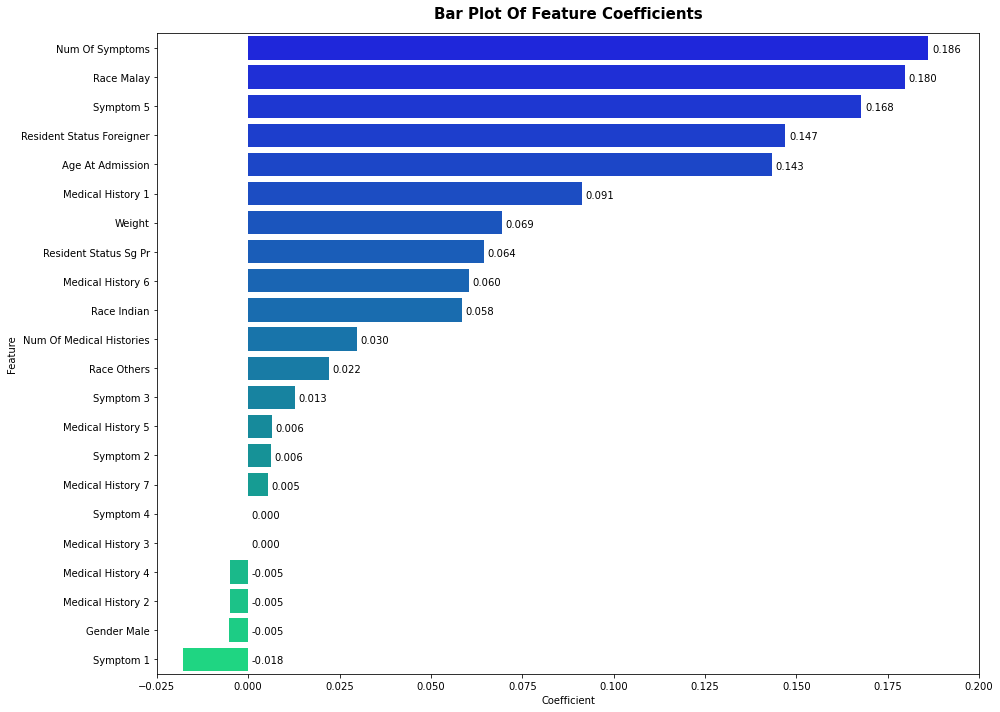

In [133]:
# visualise bar plot of feature coefficients
# to evaluate feature importance
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 10), sharex=False, sharey=False)

title_kws = {'pad': 15, 'fontweight': 'bold', 'fontsize': 15}

sns.barplot(
    data=feat_coef,
    x='Coefficient',
    y='Feature',
    ax=ax,
    palette='winter',
)

ax.set_title('Bar Plot Of Feature Coefficients', **title_kws)
ax.set_xlim(-0.025, 0.2)

for i, coef in enumerate(feat_coef['Coefficient']):
    if coef >= 0:
        ax.text(coef+0.001, i+0.15, f'{coef:.3f}')
    else:
        ax.text(0.001, i+0.15, f'{coef:.3f}')

fig.tight_layout()

fig.savefig(plots_dir.joinpath('feature_coefficients.png'), bbox_inches='tight', transparent=True)

**Interpretation:**

First, we focus on the demographic features.

1. Gender
  - A Male patient can be expected to pay less than a Female patient which is the baseline `gender`
  - However, the effect of `gender` on the bill amount is negligible


2. Race
 - A Malay, Indian, or Other patient can be expected to pay more than a Chinese patient which is the baseline `race`
 - The increase in bill amount is biggest for a Malay, followed by an Indian, and then an Other
 - Differences in `race` have a significant effect on the bill amount


3. Resident Status
 - A Foreigner or Singapore PR patient can be expected to pay more than a Singapore Citizen patient which is the baseline `resident_status`
 - The increase in bill amount is bigger for a Foreigner than a Singapore PR
 - Differences in `resident_status` have a significant effect on the bill amount


Next, we focus on the clinical features.

4. Medical History 1-7 | Number Of Medical Histories
 - `medical_history_1` and `medical_history_6` lead to a noticeable increase in the bill amount
 - `medical_history_2` and `medical_history_4` result in a slight decrease in the bill amount
 - `num_of_medical_histories` is a weak predictor of the bill amount


5. Symptom 1-5 | Number Of Symptoms
 - `symptom_5` leads to a substantial increase in the bill amount
 - `symptom_1` results in a minor decrease in the bill amount
 - `num_of_symptoms` is the most important feature explaining bill amount


Last, we focus on the physical features.

6. Weight
 - `weight` is a mediocre predictor of the bill amount
 - A heavier patient can be expected to have a higher bill amount


7. Age At Admission
 - `age_at_admission` is a strong predictor of the bill amount
 - An older patient can be expected to have a higher bill amount

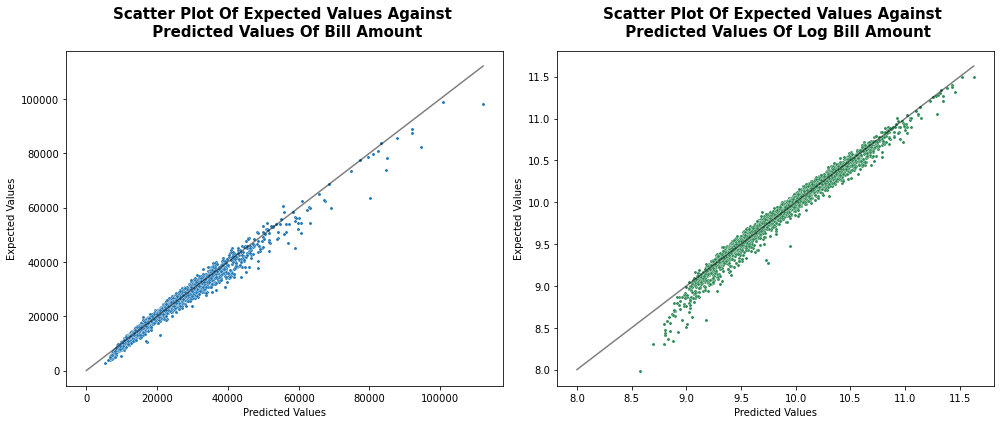

In [134]:
# visualise scatter plots of expected values against predicted values
# to evaluate goodness-of-fit of model
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharex=False, sharey=False)

title_kws = {'pad': 15, 'fontweight': 'bold', 'fontsize': 15}

sns.scatterplot(
    x=np.exp(log_y_pred),
    y=np.exp(log_y),
    s=10,
    alpha=1,
    ax=ax[0],
)
sns.lineplot(
    x=[0, max(np.max(np.exp(log_y)), np.max(np.exp(log_y_pred)))],
    y=[0, max(np.max(np.exp(log_y)), np.max(np.exp(log_y_pred)))],
    linewidth=1.5,
    alpha=0.5,
    ax=ax[0],
    color='black',
)

ax[0].set_title('Scatter Plot Of Expected Values Against \n Predicted Values Of Bill Amount', **title_kws)
ax[0].set_ylabel('Expected Values')
ax[0].set_xlabel('Predicted Values')

sns.scatterplot(
    x=log_y_pred,
    y=log_y,
    s=10,
    alpha=1,
    ax=ax[1],
    color='seagreen',
)
sns.lineplot(
    x=[8, max(np.max(log_y), np.max(log_y_pred))],
    y=[8, max(np.max(log_y), np.max(log_y_pred))],
    linewidth=1.5,
    alpha=0.5,
    ax=ax[1],
    color='black',
)

ax[1].set_title('Scatter Plot Of Expected Values Against \n Predicted Values Of Log Bill Amount', **title_kws)
ax[1].set_ylabel('Expected Values')
ax[1].set_xlabel('Predicted Values')

fig.tight_layout()

fig.savefig(plots_dir.joinpath('expected_predicted.png'), bbox_inches='tight', transparent=True)

**Interpretation:** The predicted values by the lasso regression model are very similar to the expected values in the dataset. Most of the data points lie very close to the 1:1 origin line which indicates a perfect prediction wherein the predicted value is equal to the expected value.

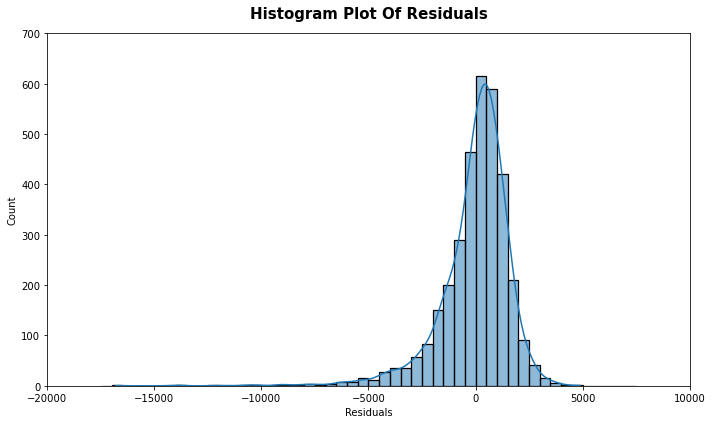

In [135]:
# visualise histogram plot of residuals
# to evaluate normality of residuals
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharex=False, sharey=False)

title_kws = {'pad': 15, 'fontweight': 'bold', 'fontsize': 15}

sns.histplot(
    data=residuals,
    binwidth=500,
    binrange=(-17500, 7500),
    kde=True,
    linewidth=1.25,
    ax=ax,
)

ax.set_title('Histogram Plot Of Residuals', **title_kws)
ax.set_ylabel('Count')
ax.set_xlabel('Residuals')
ax.set_ylim(0, 700)
ax.set_xlim(-20000, 10000)

fig.tight_layout()

fig.savefig(plots_dir.joinpath('residuals_normality.png'), bbox_inches='tight', transparent=True)

**Interpretation:** Ideally, the residuals should be normally distributed. However, the distribution of residuals is asymmetrical with a negative or left skew. There are a few predicted values by the lasso regression model that are way higher than the expected values, which results in there being extremely negative residuals.

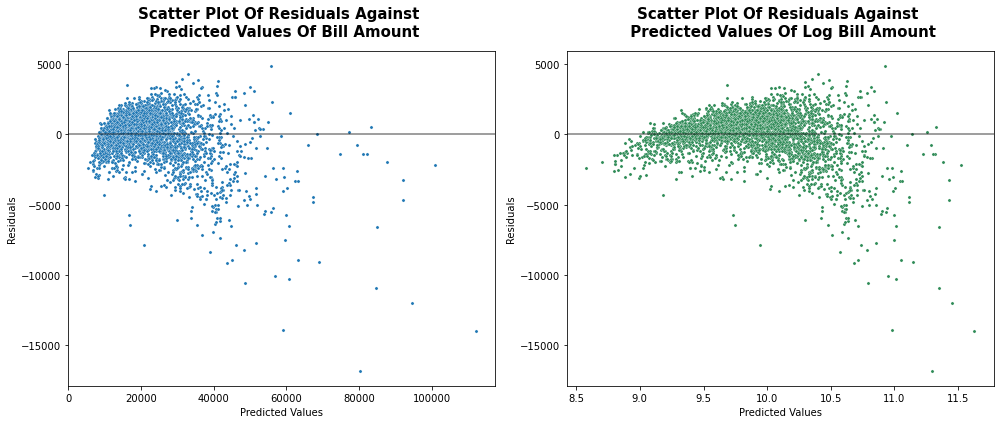

In [136]:
# visualise scatter plots of residuals against predicted values
# to evaluate homoscedasticity of residuals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharex=False, sharey=False)

title_kws = {'pad': 15, 'fontweight': 'bold', 'fontsize': 15}

sns.scatterplot(
    x=np.exp(log_y_pred),
    y=residuals,
    s=10,
    alpha=1,
    ax=ax[0],
)
ax[0].axhline(
    0,
    linewidth=1.5,
    alpha=0.5,
    color='black',
)

ax[0].set_title('Scatter Plot Of Residuals Against \n Predicted Values Of Bill Amount', **title_kws)
ax[0].set_ylabel('Residuals')
ax[0].set_xlabel('Predicted Values')

sns.scatterplot(
    x=log_y_pred,
    y=residuals,
    s=10,
    alpha=1,
    ax=ax[1],
    color='seagreen',
)
ax[1].axhline(
    0,
    linewidth=1.5,
    alpha=0.5,
    color='black',
)

ax[1].set_title('Scatter Plot Of Residuals Against \n Predicted Values Of Log Bill Amount', **title_kws)
ax[1].set_ylabel('Residuals')
ax[1].set_xlabel('Predicted Values')

fig.tight_layout()

fig.savefig(plots_dir.joinpath('residuals_homoscedasticity.png'), bbox_inches='tight', transparent=True)

**Interpretation:** Ideally, the residuals should have homoscedasticity or equal variance. For smaller predicted values, this condition is mostly satisfied. There is a certain equal distribution of data points above and below the zero line. However, for bigger predicted values, this condition is only somewhat satisfied. The data points are mainly below the zero line, which indicates that the predicted values have over-estimated the expected values, thereby resulting in there being extremely negative residuals.

### Null Model

In [137]:
# create null model to serve as baseline model
y_null = np.full(df['bill_amount'].shape, df['bill_amount'].mean())

# get baseline prediction
round(df['bill_amount'].mean(), 3)

21859.071

**Interpretation:** The null model has a baseline prediction of $21,859.071 as the bill amount of all patients.

In [138]:
# get baseline r2
round(r2_score(df['bill_amount'], y_null), 3)

0.0

**Interpretation:** The null model has a baseline R² of 0. This loses out to the lasso regression model which obtained a final R² of 0.973.

In [139]:
# get baseline rmse
round(mean_squared_error(df['bill_amount'], y_null, squared=False), 3)

10153.843

**Interpretation:** The null model has a baseline RMSE of 10,153.843. This loses out to the lasso regression model which obtained a final RMSE of 1,654.237.

## Recommendations

Some recommendations can be made based on the analysis of the data.

#### 1. Symptoms & Medical Histories

`symptom_5`, `medical_history_1`, and `medical_history_6` are key features that have a significant influence on the bill amount. ABC Health Insurance could construct all their policies to include mandatory entry-level coverage of these conditions so that there will be a large base of paying customers to shoulder the costs of claim payouts, which are expected to be huge. This has the dual advantage of keeping the premiums affordable and ensuring that patients who have these conditions receive adequate monetary benefits.

#### 2. Race

`race` is a factor that plays a huge role in deciding the bill amount. Malay patients are predicted to have the highest bill amount, followed by Indian patients, Other patients, and then Chinese patients. ABC Health Insurance would need to conduct further studies to investigate if there are confounding variables that could explain the racial differences in the bill amount and incorporate those findings in their policies. [Ethnic predisposition to different diseases](https://psomagen.com/race-and-predisposition-to-disease/) is a frequently-discussed topic. In Singapore, this [newspaper article](https://www.straitstimes.com/singapore/health/malay-population-the-most-unhealthy-group-in-singapore) highlighted that a disproportionate number of patients with diabetes, kidney failure, heart attack, and stroke come from the Malay population. Hence, Malay patients could be incurring higher bill amounts than their racial counterparts because they might be more inclined to chronic diseases which would increase their hospitalisation burden.

#### 3. Weight

`weight` is a factor that has a moderately important place in determining the bill amount. Patients with heavier weights are predicted to have larger bill amounts. A [systematic literature review on the economic burden for obesity](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5409636/) discovered that obesity is responsible for a large fraction of costs for both healthcare systems and the society. However, insurance companies are still divided on [whether to view obesity as a disease or not](https://www.healthline.com/health/is-obesity-a-disease). ABC Health Insurance could start to make provisions recognising obesity as a disease and begin to provide coverage and benefits for patients seeking obesity treatment.

## Limitations

There are a few limitations to this project.

#### 1. Absence of critical features

Information on some of the major determinants of hospitalisation costs such as type of surgery, experience of attending doctor, any imaging done, ward class, admission to an intensive care unit or a high dependency unit, and treatment at a public hospital or private hospital are absent. This [study on the predictors of acute hospital costs](https://www.ahajournals.org/doi/full/10.1161/01.STR.30.4.724) found that room charges account for 50% of hospitalisation costs. The presence of these predictors could potentially lead to a better estimation of bill amount and provide a stronger understanding of the factors driving the cost of care.

#### 2. Inadequacy of existing features

Due to an anonymisation of the data, features such as `medical_history`, `pre-op_medication`, `symptom`, and `lab_result` have been left vague intentionally. This makes it challenging to apply any domain-specific knowledge into the creation of interaction features. As for `symptom` and `lab_result`, it is uncertain at what point during the patient's hospital stay was the information captured. This [study on the factors affecting healthcare costs](https://pubmed.ncbi.nlm.nih.gov/18387070/) acknowledged that hospitalisation costs are the summation costs of various utilised resources which would include drugs, medical supplies, and lab tests. In this instance, it would be beneficial to know the number of medications served and the number of lab tests done for each patient.

#### 3. Limited data on recurring hospitalisations

Of the 3,400 rows in the dataset, 3,000 rows were first-time admissions and 400 rows were repeating admissions. To better study the effect of recurring hospitalisations on bill amount, more data on repeating admissions would be needed. There are 2 features that were engineered to investigate this effect: `days_hospitalised` and `days_since_last_hospitalisation`. However, they had to be dropped eventually due to their low variance since the majority of patients are one-time visitors to the hospital.

## Conclusion

The final lasso regression model has performed well as it is able to explain 97.3% of the total variability in the bill amount with all the features and is generally off-the-mark by 7% on its predictions of the bill amount. It has found the main factors driving cost of care to be `num_of_symptoms`, which is the most important feature predicting bill amount, as well as `race`, `resident_status`, `age_at_admission`, and `weight`, which are among the top few features explaining bill amount.

The future plans for this project could involve extending it to other cities and countries to find the factors driving their cost of care so as to help solve various healthcare problems that are not just limited to the area of health insurance, or adapting it to predict hospital bills at pre-admission by providing patients with up-front cost estimates to help reduce bill shocks and payment challenges after treatment.

## References

[1] https://www.dbs.com.sg/personal/articles/nav/protection/guide-health-insurance-singapore-medishield-medisave?pid=sg-dbs-pweb-insure-product-firstinsurance-image-textlink-medishield-medisave<br>
[2] https://www.dbs.com.sg/personal/articles/nav/protection/integrated-shield-plans<br>
[3] https://www.straitstimes.com/singapore/health/moh-welcomes-measures-by-insurers-to-adjust-terms-for-full-rider-ips-and-require-co<br>